<a href="https://colab.research.google.com/github/belanatal/PosPuc/blob/main/MVP-SprintI_IsabelaNatal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PUC Rio: Pós Graduação em Ciência de Dados e Analytics**

**MVP Sprint I: Análise de Dados e Boas Práticas (40530010055_20230_01)**

Aluna: Isabela Fernanda Natal Batista Abreu Gomes

Maio/2023

# **Introdução**

## Programa para obtenção, tratamento e análise do histórico de Energia Natural Afluente (ENA), da Energia Armazenada (EArm), da Demanda/Carga e do Custo Marginal da Operação (CMO) por subsistema, a partir da área de Dados Abertos do Operador Nacional do Sistema Elétrico (ONS): [Arquitetura Aberta](https://dados.ons.org.br/)

> Bloco com recuo




> No Brasil, a projeção de preços da energia elétrica baseia-se na previsão, centralizada, de despacho das usinas pelo Operador Nacional do Sistema Elétrico (ONS). 

> Em linhas gerais, o preço da energia, também chamado de Preço de Liquidação das Diferenças (PLD) tem como base o Custo Marginal da Operação (CMO), dado pelo planejamento da operação hidrotérmica do Sistema Interligado Nacional. Os modelos utilizados para projeção oficial do despacho das usinas pelo ONS (Operador Nacional do Sistema) denominam-se NEWAVE, DECOMP e DESSEM, todos desenvolvidos e fornecidos pelo Centro de Pesquisas da Eletrobras (CEPEL), conforme ilustrado na Figura 1.

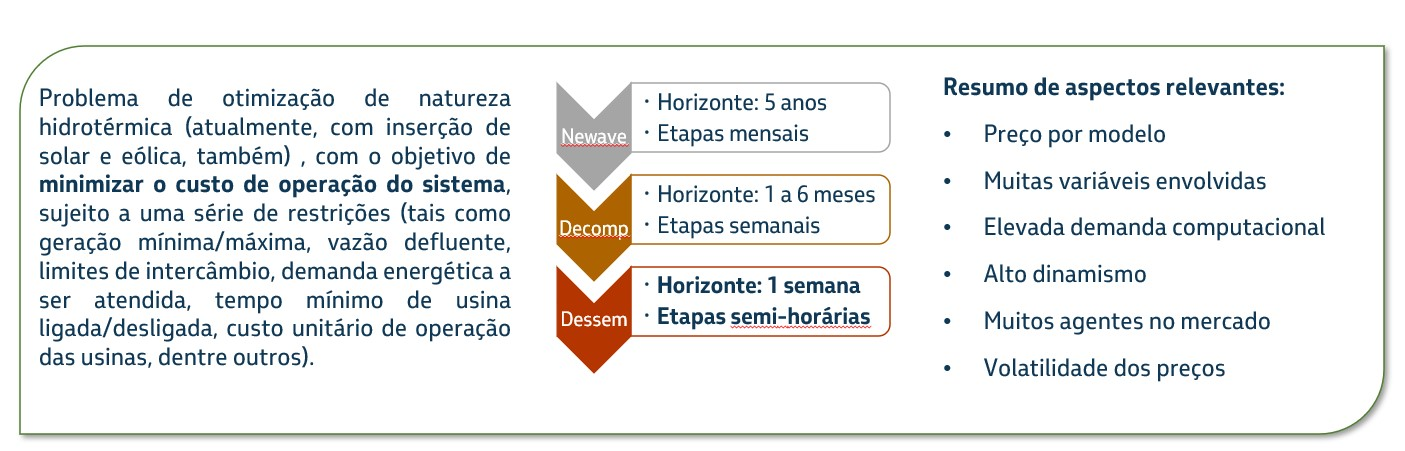

Figura 1 - Resumo do problema de planejamento eletroenergético brasileiro.

> Para a projeção do preço da energia elétrica, uma série de grandezas são utilizadas como entrada. Uma vez que a matriz eletroenergética brasileira é predominantemente hidráulica (e os modelos consideram este aspecto no equacionamento do problema de otimização), a diferença entre as vazões previstas e verificadas dos postos associados às usinas hidroelétricas responde por cerca de 50% das variações no PLD/CMO, conforme ilustrado na Figura 2, disponibilizada pela Câmara de Comercialização de Energia (CCEE). A Energia Armazenada e a Carga também desempenham papel relevante na influência do PLD/CMO. Juntas, as três grandezas respondem por mais de 70% das variações no custo marginal da operação sendo, portanto, as variáveis de interesse na primeira abordagem deste MVP.

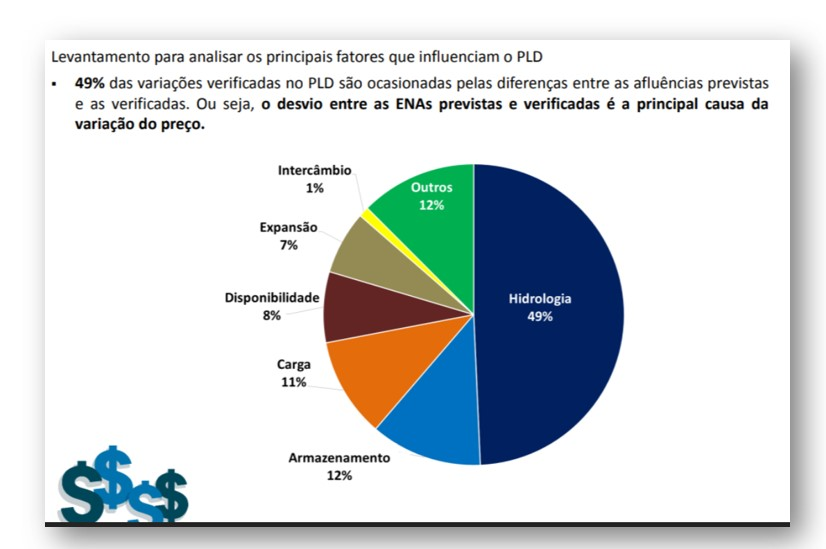

Figura 2 - Variação do PLD/CMO por variável de entrada nos modelos de planejamento eletroenergético do SIN. Fonte: CCEE


> Neste contexto, considerando a atuação na área de Inteligência de Mercado de Gás e Energia em um dos principais agentes geradores do Brasil, faz sentido estruturarmos a coleta e tratamento dos dados referentes às grandezas mencionadas, visando à melhor tomada de decisão sob a ótica da operação do parque e da comercialização e logística do gás e da energia elétrica.





# **Seção I: Obtenção e Tratamento Inicial dos Dados**


1.   [Energia Natural Afluente (ENA) por Subsistema](https://dados.ons.org.br/dataset/ena-diario-por-subsistema)
2.   [Energia Armazenada (EArm) por Subsistema](https://dados.ons.org.br/dataset/ear-diario-por-subsistema)
3.   [Demanda por Subsistema](https://dados.ons.org.br/dataset/carga-energia)
4.   [Custo Marginal da Operação (CMO) Semanal por Subsistema](https://dados.ons.org.br/dataset/cmo-semanal)





> Diariamente, o Operador Nacional do Sistema Elétrico disponibiliza os dados verificados das grandezas supracitadas, para cada um dos 4 subsistemas (Sudeste, Sul, Nordeste e Norte) que compõem eletroenergeticamente o Sistema Interligado Nacional. Para atender ao presente trabalho, estes dados serão tratados, manipulados, pré-processados e avaliados de modo que, em etapas futuras, seja possível aplicar técnicas e algoritmos de Machine Learning a eles, com o objetivo de tentar realizar predições e análises de sensibilidade de Custos Marginais da Operação futuros, por fora dos modelos oficiais.

> Trata-se, portanto, de um problema de Aprendizado Supervisionado, considerando as principais grandezas envolvidas no cálculo do CMO, segundo a Câmara de Comercialização de Energia.



Inicialmente, iremos importar e avaliar (utilizando a biblioteca Pandas, para fazer uma rápida análise exploratória) os dataset de "entrada", variáveis explicativas para a obtenção do CMO: ENA, EArm e Demanda, nesta ordem.

In [430]:
# Primeiro bloco: Importação das bibliotecas e módulos
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")
#
# Importando as bibliotecas pandas, matplotlib (pyplot), seaborn e datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
# Importando o módulo para download a partir do Colab
from google.colab import files
#
## Transformações Numéricas e ML
from sklearn.preprocessing import MinMaxScaler # para normalização
from sklearn.preprocessing import StandardScaler # para padronização
from sklearn.model_selection import train_test_split
## Transformações Categóricas
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

## Energia Natural Afluente: ENA

***ENA DIÁRIO POR SUBSISTEMA*** (Segundo o ONS)

Dados das grandezas de energia natural afluente (ENA) dos reservatórios com periodicidade diária por Subsistemas.

A Energia Natural Afluente (ENA) Bruta representa a energia produzível pela usina e é calculada pelo produto das vazões naturais aos reservatórios com as produtividades a 65% dos volumes úteis. A ENA Armazenável considera as vazões naturais descontadas das vazões vertidas nos reservatórios.

Como esses dados podem ser utilizados: os dados podem servir de insumo para estudos energéticos e projeção do custo marginal de operação. Contudo, saiba que os dados disponibilizados fazem parte de um processo de consistência recorrente e, portanto, podem ser atualizados após a sua publicação.

In [431]:
# Seção I.1: Programa para obtenção das Energias Naturais Afluentes - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.
# ENA - Arquivos com os dados anuais, com histórico desde 2001
ano_zero=2001
ano_inicio=ano_zero+1
data_fim=datetime.datetime.now() - datetime.timedelta(days=5) #ano vigente, considerando um possível atraso de até 5 dias na publicação, o que é comum na virada de ano
ano_fim=data_fim.strftime("%Y")
ano_fim=int(ano_fim)
print(data_fim)
print(ano_fim)

2023-04-29 00:28:32.703965
2023


In [432]:
#Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
#Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
ena=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ena_subsistema_di/ENA_DIARIO_SUBSISTEMA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
ena=pd.DataFrame(ena)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)  
    ena_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ena_subsistema_di/ENA_DIARIO_SUBSISTEMA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    ena_ano=pd.DataFrame(ena_ano)
    ena=pd.concat([ena,ena_ano])
print(ena)

    id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
0               N          NORTE  2001-01-01            10154.000000   
1              NE       NORDESTE  2001-01-01            13472.000000   
2               S            SUL  2001-01-01             7703.000000   
3              SE        SUDESTE  2001-01-01            39186.000000   
4               N          NORTE  2001-01-02             9590.000000   
..            ...            ...         ...                     ...   
483            SE        SUDESTE  2023-05-01            49685.988281   
484             N          NORTE  2023-05-02            23127.919922   
485            NE       NORDESTE  2023-05-02             4596.839844   
486             S            SUL  2023-05-02             4514.132812   
487            SE        SUDESTE  2023-05-02            48473.257812   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                        122.339996                   9033.000000 

In [433]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
ena.head(10)

id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
0             N          NORTE  2001-01-01                 10154.0   
1            NE       NORDESTE  2001-01-01                 13472.0   
2             S            SUL  2001-01-01                  7703.0   
3            SE        SUDESTE  2001-01-01                 39186.0   
4             N          NORTE  2001-01-02                  9590.0   
5            NE       NORDESTE  2001-01-02                 13551.0   
6             S            SUL  2001-01-02                  6730.0   
7            SE        SUDESTE  2001-01-02                 41230.0   
8             N          NORTE  2001-01-03                  9066.0   
9            NE       NORDESTE  2001-01-03                 13551.0   

   ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                      122.339996                        9033.0   
1                      101.480003                       13385.0   
2                      160.910004                        7703.0   
3                       86.980003                       37611.0   
4                      115.550003                        8091.0   
5                      102.080002                       13465.0   
6                      140.580002                        6730.0   
7                       91.519997                       40063.0   
8                      109.239998                        7213.0   
9                      102.080002                       13461.0   

   ena_armazenavel_regiao_percentualmlt  
0                            108.839996  
1                            100.830002  
2                            160.910004  
3                             83.489998  
4                             97.489998  
5                            101.430000  
6                            140.580002  
7                             88.930000  
8                             86.910004  
9                            101.400002

In [434]:
# Conferindo as últimas 10 linhas
ena.tail(10)

id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
478             S            SUL  2023-04-30             5107.277832   
479            SE        SUDESTE  2023-04-30            51014.507812   
480             N          NORTE  2023-05-01            23552.435547   
481            NE       NORDESTE  2023-05-01             4482.237793   
482             S            SUL  2023-05-01             4759.590820   
483            SE        SUDESTE  2023-05-01            49685.988281   
484             N          NORTE  2023-05-02            23127.919922   
485            NE       NORDESTE  2023-05-02             4596.839844   
486             S            SUL  2023-05-02             4514.132812   
487            SE        SUDESTE  2023-05-02            48473.257812   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
478                       78.512703                   4844.181152   
479                       93.176804                  32112.384766   
480                      115.651703                  15772.394531   
481                       64.583504                   4461.502930   
482                       55.879601                   4196.793945   
483                      124.491302                  31941.660156   
484                      113.567200                  15596.257812   
485                       66.234802                   4587.544922   
486                       52.997799                   4302.372070   
487                      121.452797                  35527.921875   

     ena_armazenavel_regiao_percentualmlt  
478                             74.468201  
479                             58.652500  
480                             77.448700  
481                             64.284798  
482                             49.272099  
483                             80.031799  
484                             76.583801  
485                             66.100899  
486                             50.511700  
487                             89.017403

In [435]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(ena)/4

8157.0

In [436]:
# Verificando os tipos de coluna do dataframe ena
ena.dtypes

id_subsistema                            object
nom_subsistema                           object
ena_data                                 object
ena_bruta_regiao_mwmed                  float64
ena_bruta_regiao_percentualmlt          float64
ena_armazenavel_regiao_mwmed            float64
ena_armazenavel_regiao_percentualmlt    float64
dtype: object

In [437]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
ena['nom_subsistema']=ena['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [438]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
ena=ena.rename(columns = {'ena_data':'Data'})
print(ena)

    id_subsistema nom_subsistema        Data  ena_bruta_regiao_mwmed  \
0               N          Norte  2001-01-01            10154.000000   
1              NE       Nordeste  2001-01-01            13472.000000   
2               S            Sul  2001-01-01             7703.000000   
3              SE        Sudeste  2001-01-01            39186.000000   
4               N          Norte  2001-01-02             9590.000000   
..            ...            ...         ...                     ...   
483            SE        Sudeste  2023-05-01            49685.988281   
484             N          Norte  2023-05-02            23127.919922   
485            NE       Nordeste  2023-05-02             4596.839844   
486             S            Sul  2023-05-02             4514.132812   
487            SE        Sudeste  2023-05-02            48473.257812   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                        122.339996                   9033.000000 

In [439]:
# Alterando o tipo da coluna "Data"
ena['Data'] = pd.to_datetime(ena['Data'])

In [440]:
# Verificando os tipos de coluna do dataframe ena
ena.dtypes

id_subsistema                                   object
nom_subsistema                                  object
Data                                    datetime64[ns]
ena_bruta_regiao_mwmed                         float64
ena_bruta_regiao_percentualmlt                 float64
ena_armazenavel_regiao_mwmed                   float64
ena_armazenavel_regiao_percentualmlt           float64
dtype: object

In [441]:
# Reordenando o dataframe ena, pela coluna Data (em ordem decrescente)
ena=ena.sort_values(by='Data', ascending=False)
ena.head(20)

id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
487            SE        Sudeste 2023-05-02            48473.257812   
486             S            Sul 2023-05-02             4514.132812   
485            NE       Nordeste 2023-05-02             4596.839844   
484             N          Norte 2023-05-02            23127.919922   
483            SE        Sudeste 2023-05-01            49685.988281   
482             S            Sul 2023-05-01             4759.590820   
481            NE       Nordeste 2023-05-01             4482.237793   
480             N          Norte 2023-05-01            23552.435547   
479            SE        Sudeste 2023-04-30            51014.507812   
478             S            Sul 2023-04-30             5107.277832   
477            NE       Nordeste 2023-04-30             4439.373047   
476             N          Norte 2023-04-30            24059.865234   
474             S            Sul 2023-04-29             5558.620117   
472             N          Norte 2023-04-29            24506.572266   
473            NE       Nordeste 2023-04-29             4434.699219   
475            SE        Sudeste 2023-04-29            52400.800781   
471            SE        Sudeste 2023-04-28            53724.859375   
470             S            Sul 2023-04-28             6061.600098   
469            NE       Nordeste 2023-04-28             4414.454102   
468             N          Norte 2023-04-28            24884.140625   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
487                      121.452797                  35527.921875   
486                       52.997799                   4302.372070   
485                       66.234802                   4587.544922   
484                      113.567200                  15596.257812   
483                      124.491302                  31941.660156   
482                       55.879601                   4196.793945   
481                       64.583504                   4461.502930   
480                      115.651703                  15772.394531   
479                       93.176804                  32112.384766   
478                       78.512703                   4844.181152   
477                       38.630699                   4420.783203   
476                       89.216904                  16730.607422   
474                       85.451103                   5203.178223   
472                       90.873299                  17543.970703   
473                       38.590000                   4423.974121   
475                       95.708801                  34929.644531   
471                       98.127098                  39116.824219   
470                       93.183197                   5920.476074   
469                       38.413898                   4407.304199   
468                       92.273399                  18524.371094   

     ena_armazenavel_regiao_percentualmlt  
487                             89.017403  
486                             50.511700  
485                             66.100899  
484                             76.583801  
483                             80.031799  
482                             49.272099  
481                             64.284798  
480                             77.448700  
479                             58.652500  
478                             74.468201  
477                             38.468899  
476                             62.039101  
474                             79.987000  
472                             65.055199  
473                             38.496700  
475                             63.798100  
471                             71.445900  
470                             91.013802  
469                             38.351601  
468                             68.690598

## Energia Armazenada: EArm

***EAR DIÁRIO POR SUBSISTEMA*** (Segundo o ONS)

Dados das grandezas de energia armazenada (EAR) em periodicidade diária por Subsistemas.

A Energia Armazenada (EAR) representa a energia associada ao volume de água disponível nos reservatórios que pode ser convertido em geração na própria usina e em todas as usinas à jusante na cascata. A grandeza de EAR leva em conta nível verificado nos reservatórios na data de referência. A grandeza de EAR máxima representa a capacidade de armazenamento caso todos os reservatórios do sistema estivessem cheios. A grandeza de EAR para o subsistema à jusante considera a utilização da água do reservatório para produzir energia em uma usina à jusante que está em um subsistema diferente.

Como esses dados podem ser utilizados: os dados podem servir de insumo para estudos energéticos e projeção do custo marginal de operação. Contudo, saiba que os dados disponibilizados fazem parte de um processo de consistência recorrente e, portanto, podem ser atualizados após a sua publicação.

In [442]:
# Seção I.2: Programa para obtenção das Energias Armazenadas - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# EArm - Arquivos com os dados anuais, com histórico desde 2001. 
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas)
# Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
earm=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ear_subsistema_di/EAR_DIARIO_SUBSISTEMA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
earm=pd.DataFrame(earm)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)  
    earm_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ear_subsistema_di/EAR_DIARIO_SUBSISTEMA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    earm_ano=pd.DataFrame(earm_ano)
    earm=pd.concat([earm,earm_ano])
print (earm)

    id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
0              NE       NORDESTE  2001-01-01        49967.000000   
1               N          NORTE  2001-01-01        12311.000000   
2              SE        SUDESTE  2001-01-01       159081.000000   
3               S            SUL  2001-01-01        14176.000000   
4              NE       NORDESTE  2001-01-02        49967.000000   
..            ...            ...         ...                 ...   
483             S            SUL  2023-05-01        20459.242188   
484            NE       NORDESTE  2023-05-02        51691.226562   
485             N          NORTE  2023-05-02        15302.396484   
486            SE        SUDESTE  2023-05-02       204615.328125   
487             S            SUL  2023-05-02        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                  18699.000000                        37.419998  
1                   9137.000000                  

In [443]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
earm.head(10)

id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
0            NE       NORDESTE  2001-01-01             49967.0   
1             N          NORTE  2001-01-01             12311.0   
2            SE        SUDESTE  2001-01-01            159081.0   
3             S            SUL  2001-01-01             14176.0   
4            NE       NORDESTE  2001-01-02             49967.0   
5             N          NORTE  2001-01-02             12311.0   
6            SE        SUDESTE  2001-01-02            159081.0   
7             S            SUL  2001-01-02             14176.0   
8            NE       NORDESTE  2001-01-03             49967.0   
9             N          NORTE  2001-01-03             12311.0   

   ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                     18699.0                        37.419998  
1                      9137.0                        74.220001  
2                     46315.0                        29.110001  
3                     12857.0                        90.690002  
4                     18851.0                        37.730000  
5                      9327.0                        75.760002  
6                     46850.0                        29.450001  
7                     12920.0                        91.139999  
8                     19047.0                        38.119999  
9                      9453.0                        76.779999

In [444]:
# Conferindo as últimas 10 linhas
earm.tail(10)

id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
478            SE        SUDESTE  2023-04-30       204615.328125   
479             S            SUL  2023-04-30        20459.242188   
480            NE       NORDESTE  2023-05-01        51691.226562   
481             N          NORTE  2023-05-01        15302.396484   
482            SE        SUDESTE  2023-05-01       204615.328125   
483             S            SUL  2023-05-01        20459.242188   
484            NE       NORDESTE  2023-05-02        51691.226562   
485             N          NORTE  2023-05-02        15302.396484   
486            SE        SUDESTE  2023-05-02       204615.328125   
487             S            SUL  2023-05-02        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
478               176401.640625                        86.211403  
479                17196.074219                        84.050400  
480                47046.167969                        91.013802  
481                15098.113281                        98.665001  
482               176441.796875                        86.231003  
483                17187.488281                        84.008400  
484                47036.906250                        90.995903  
485                15044.594727                        98.315300  
486               176293.968750                        86.158699  
487                17120.068359                        83.678902

In [445]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(earm)/4

8157.0

In [446]:
# Verificando os tipos de coluna do dataframe earm
earm.dtypes

id_subsistema                       object
nom_subsistema                      object
ear_data                            object
ear_max_subsistema                 float64
ear_verif_subsistema_mwmes         float64
ear_verif_subsistema_percentual    float64
dtype: object

In [447]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
earm['nom_subsistema']=earm['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [448]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
earm=earm.rename(columns = {'ear_data':'Data'})
print(earm)

    id_subsistema nom_subsistema        Data  ear_max_subsistema  \
0              NE       Nordeste  2001-01-01        49967.000000   
1               N          Norte  2001-01-01        12311.000000   
2              SE        Sudeste  2001-01-01       159081.000000   
3               S            Sul  2001-01-01        14176.000000   
4              NE       Nordeste  2001-01-02        49967.000000   
..            ...            ...         ...                 ...   
483             S            Sul  2023-05-01        20459.242188   
484            NE       Nordeste  2023-05-02        51691.226562   
485             N          Norte  2023-05-02        15302.396484   
486            SE        Sudeste  2023-05-02       204615.328125   
487             S            Sul  2023-05-02        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                  18699.000000                        37.419998  
1                   9137.000000                  

In [449]:
# Alterando o tipo da coluna "Data"
earm['Data'] = pd.to_datetime(earm['Data'])

In [450]:
# Verificando novamente os tipos de coluna do dataframe earm
earm.dtypes

id_subsistema                              object
nom_subsistema                             object
Data                               datetime64[ns]
ear_max_subsistema                        float64
ear_verif_subsistema_mwmes                float64
ear_verif_subsistema_percentual           float64
dtype: object

In [451]:
# Reordenando o dataframe earm, pela coluna Data (em ordem decrescente)
earm=earm.sort_values(by='Data', ascending=False)
earm.head(20)

id_subsistema nom_subsistema       Data  ear_max_subsistema  \
487             S            Sul 2023-05-02        20459.242188   
486            SE        Sudeste 2023-05-02       204615.328125   
485             N          Norte 2023-05-02        15302.396484   
484            NE       Nordeste 2023-05-02        51691.226562   
483             S            Sul 2023-05-01        20459.242188   
482            SE        Sudeste 2023-05-01       204615.328125   
481             N          Norte 2023-05-01        15302.396484   
480            NE       Nordeste 2023-05-01        51691.226562   
479             S            Sul 2023-04-30        20459.242188   
478            SE        Sudeste 2023-04-30       204615.328125   
477             N          Norte 2023-04-30        15302.396484   
476            NE       Nordeste 2023-04-30        51691.226562   
474            SE        Sudeste 2023-04-29       204615.328125   
472            NE       Nordeste 2023-04-29        51691.226562   
473             N          Norte 2023-04-29        15302.396484   
475             S            Sul 2023-04-29        20459.242188   
471             S            Sul 2023-04-28        20459.242188   
470            SE        Sudeste 2023-04-28       204615.328125   
469             N          Norte 2023-04-28        15302.396484   
468            NE       Nordeste 2023-04-28        51691.226562   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
487                17120.068359                        83.678902  
486               176293.968750                        86.158699  
485                15044.594727                        98.315300  
484                47036.906250                        90.995903  
483                17187.488281                        84.008400  
482               176441.796875                        86.231003  
481                15098.113281                        98.665001  
480                47046.167969                        91.013802  
479                17196.074219                        84.050400  
478               176401.640625                        86.211403  
477                15065.079102                        98.449203  
476                47074.093750                        91.067902  
474               176315.453125                        86.169197  
472                47102.566406                        91.122902  
473                14996.313477                        97.999802  
475                17183.201172                        83.987503  
471                17181.691406                        83.980103  
470               176424.250000                        86.222397  
469                14965.521484                        97.798500  
468                47129.378906                        91.174797

## Carga (Demanda) Eletroenergética

***CARGA DE ENERGIA DIÁRIA*** (Segundo o ONS)

Dados de carga por subsistema em base diária, medida em MWmed.

Até fevereiro/2021, os dados representam a carga atendida por usinas despachadas e/ou programadas pelo ONS, com base em dados recebidos pelo Sistema de Supervisão e Controle do ONS. Entre março/2021 e abril/23, os dados representam a carga atendida por usinas despachadas e/ou programadas pelo ONS, com base em dados recebidos pelo Sistema de Supervisão e Controle do ONS, mais a previsão de geração de usinas não despachadas pelo ONS. A partir de 29/04/2023, além dos dados anteriormente considerados, passou a ser incorporado o valor estimado da micro e minigeração distribuída (MMGD), com base em dados meteorológicos previstos.

In [452]:
# Seção I.3: Programa para obtenção da Carga Elétrica - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# Carga - Arquivos com os dados anuais, com histórico desde 2001. 
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas)
# Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
carga=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
carga=pd.DataFrame(carga)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)  
    carga_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    carga_ano=pd.DataFrame(carga_ano)
    carga=pd.concat([carga,carga_ano])
print(carga)

    id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
0               N                 Norte   2001-01-01            2376.731250
1              NE              Nordeste   2001-01-01            5035.816667
2               S                   Sul   2001-01-01            4925.373750
3              SE  Sudeste/Centro-Oeste   2001-01-01           19729.233333
4               N                 Norte   2001-01-02            2537.383333
..            ...                   ...          ...                    ...
483            SE  Sudeste/Centro-Oeste   2023-05-01           34889.841958
484             N                 Norte   2023-05-02            7120.412875
485            NE              Nordeste   2023-05-02           12121.542708
486             S                   Sul   2023-05-02           13033.734083
487            SE  Sudeste/Centro-Oeste   2023-05-02           40732.210833

[32629 rows x 4 columns]


In [453]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
carga.head(10)

id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
0             N                 Norte   2001-01-01            2376.731250
1            NE              Nordeste   2001-01-01            5035.816667
2             S                   Sul   2001-01-01            4925.373750
3            SE  Sudeste/Centro-Oeste   2001-01-01           19729.233333
4             N                 Norte   2001-01-02            2537.383333
5            NE              Nordeste   2001-01-02            5946.387500
6             S                   Sul   2001-01-02            6779.687500
7            SE  Sudeste/Centro-Oeste   2001-01-02           24596.195417
8             N                 Norte   2001-01-03            2540.345833
9            NE              Nordeste   2001-01-03            6188.104167

In [454]:
# Conferindo as últimas 10 linhas
carga.tail(10)

id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
478             S                   Sul   2023-04-30            9635.527167
479            SE  Sudeste/Centro-Oeste   2023-04-30           34584.097458
480             N                 Norte   2023-05-01            6571.352583
481            NE              Nordeste   2023-05-01           10678.087250
482             S                   Sul   2023-05-01           10072.186292
483            SE  Sudeste/Centro-Oeste   2023-05-01           34889.841958
484             N                 Norte   2023-05-02            7120.412875
485            NE              Nordeste   2023-05-02           12121.542708
486             S                   Sul   2023-05-02           13033.734083
487            SE  Sudeste/Centro-Oeste   2023-05-02           40732.210833

In [455]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(carga)/4

8157.25

In [456]:
carga_null=(carga['val_cargaenergiamwmed'].isnull() == True)
carganull=carga.loc[carga_null]
print(carganull)

     id_subsistema        nom_subsistema         din_instante  \
132              S                   Sul  2013-02-02 00:00:01   
1337             N                 Norte  2013-12-01 00:00:00   
1338            NE              Nordeste  2013-12-01 00:00:00   
1339             S                   Sul  2013-12-01 00:00:00   
1340            SE  Sudeste/Centro-Oeste  2013-12-01 00:00:00   
124              N                 Norte           2014-02-01   
125             NE              Nordeste           2014-02-01   
126              S                   Sul           2014-02-01   
127             SE  Sudeste/Centro-Oeste           2014-02-01   
392              N                 Norte           2015-04-09   
393             NE              Nordeste           2015-04-09   
394              S                   Sul           2015-04-09   
395             SE  Sudeste/Centro-Oeste           2015-04-09   
380              N                 Norte           2016-04-05   
381             NE       

Constata-se, pela quantidade de dias, que o dataframe "carga" tem uma linha a mais que os dataframes "ena" e "earm". Ao mesclarmos as consultas, desejaremos excluir essa linha a mais.

In [457]:
# Verificando os tipos de coluna do dataframe carga
carga.dtypes

id_subsistema             object
nom_subsistema            object
din_instante              object
val_cargaenergiamwmed    float64
dtype: object

In [458]:
# Iniciando o tratamento dos dados
# Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
carga['nom_subsistema']=carga['nom_subsistema'].replace({'Sudeste/Centro-Oeste':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [459]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
carga=carga.rename(columns = {'din_instante':'Data'})
print(carga)

    id_subsistema nom_subsistema        Data  val_cargaenergiamwmed
0               N          Norte  2001-01-01            2376.731250
1              NE       Nordeste  2001-01-01            5035.816667
2               S            Sul  2001-01-01            4925.373750
3              SE        Sudeste  2001-01-01           19729.233333
4               N          Norte  2001-01-02            2537.383333
..            ...            ...         ...                    ...
483            SE        Sudeste  2023-05-01           34889.841958
484             N          Norte  2023-05-02            7120.412875
485            NE       Nordeste  2023-05-02           12121.542708
486             S            Sul  2023-05-02           13033.734083
487            SE        Sudeste  2023-05-02           40732.210833

[32629 rows x 4 columns]


In [460]:
# Alterando o tipo da coluna "Data"
carga['Data'] = pd.to_datetime(carga['Data'])

In [461]:
# Verificando novamente os tipos de coluna do dataframe carga
carga.dtypes

id_subsistema                    object
nom_subsistema                   object
Data                     datetime64[ns]
val_cargaenergiamwmed           float64
dtype: object

In [462]:
# Reordenando o dataframe carga, pela coluna Data (em ordem decrescente)
carga=carga.sort_values(by='Data', ascending=False)
carga.head(20)

id_subsistema nom_subsistema       Data  val_cargaenergiamwmed
487            SE        Sudeste 2023-05-02           40732.210833
486             S            Sul 2023-05-02           13033.734083
485            NE       Nordeste 2023-05-02           12121.542708
484             N          Norte 2023-05-02            7120.412875
483            SE        Sudeste 2023-05-01           34889.841958
482             S            Sul 2023-05-01           10072.186292
481            NE       Nordeste 2023-05-01           10678.087250
480             N          Norte 2023-05-01            6571.352583
479            SE        Sudeste 2023-04-30           34584.097458
478             S            Sul 2023-04-30            9635.527167
477            NE       Nordeste 2023-04-30           11049.485958
476             N          Norte 2023-04-30            6830.589250
474             S            Sul 2023-04-29           11012.290583
472             N          Norte 2023-04-29            7139.143708
473            NE       Nordeste 2023-04-29           11854.944750
475            SE        Sudeste 2023-04-29           38139.372333
471            SE        Sudeste 2023-04-28           41438.340167
470             S            Sul 2023-04-28           12247.456792
469            NE       Nordeste 2023-04-28           11942.621250
468             N          Norte 2023-04-28            7248.208417

## Custo Marginal da Operação (CMO)

***CUSTO MARGINAL DA OPERAÇÃO*** (Segundo o ONS)

Valores do custo, por unidade de energia produzida, para atender ao incremento de uma unidade de carga no SIN, chamado de Custo Marginal de Operação – CMO. Valores para cada semana operativa por subsistema, e por patamar de carga, além da média semanal, estimados pelo modelo Decomp.

> Considerações sobre o Custo Marginal da Operação: Até 2020, o cálculo do CMO era realizado por patamar de carga (pesada, média ou leve): um único valor para cada patamar dentro da semana operativa (iniciada no sábado até a sexta-feira seguinte).  A distribuição das horas pelos patamares de carga varia de acordo com o dia da semana (se é útil ou não) e com o mês (se verão, inverno ou "intermediário"). A partir de 2020, o CMO passou a ser calculado com granularidade horária. No entanto, considerando o histórico dos últimos 3 anos, poucas foram as vezes em que houve um descolamento significativo entre o custo horário e o custo semanal. Por este motivo, para este trabalho (e para as etapas futuras), será considerado o CMO semanal, para todo o horizonte disponível. 




In [463]:
# Seção I.4: Programa para obtenção do Custo Marginal da Operação - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# CMO - Arquivos com os dados anuais, com histórico desde 2005. 
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas), à exceção do ano zero/de início
# Ao contrário das demais grandezas, os valores de CMO ora importados são semanais, vigorando do sábado à sexta-feira da semana operativa.
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
ano_zerocmo=2005
ano_iniciocmo=ano_zerocmo+1
cmo=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/cmo_se/CMO_SEMANAL_"+str(ano_zerocmo)+".csv", delimiter=";",encoding = 'utf8')
cmo=pd.DataFrame(cmo)
for ano in range (ano_iniciocmo,ano_fim+1):
    ano_str=str(ano)  
    cmo_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/cmo_se/CMO_SEMANAL_"+ano_str+".csv", delimiter=";", encoding = 'utf8')
    cmo_ano=pd.DataFrame(cmo_ano)
    cmo=pd.concat([cmo,cmo_ano])
print(cmo)

   id_subsistema nom_subsistema din_instante  val_cmomediasemanal  \
0              N          NORTE   2005-01-07                 0.94   
1             NE       NORDESTE   2005-01-07                 0.94   
2              S            SUL   2005-01-07                 4.50   
3             SE        SUDESTE   2005-01-07                 0.00   
4              N          NORTE   2005-01-14                 6.34   
..           ...            ...          ...                  ...   
67            SE        SUDESTE   2023-04-28                 0.00   
68             N          NORTE   2023-05-05                 0.00   
69            NE       NORDESTE   2023-05-05                 0.00   
70             S            SUL   2023-05-05                 0.00   
71            SE        SUDESTE   2023-05-05                 0.00   

    val_cmoleve  val_cmomedia  val_cmopesada  
0          0.94          0.94           0.94  
1          0.94          0.94           0.94  
2          4.39          4.59 

In [464]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
cmo.head(10)

id_subsistema nom_subsistema din_instante  val_cmomediasemanal  val_cmoleve  \
0             N          NORTE   2005-01-07                 0.94         0.94   
1            NE       NORDESTE   2005-01-07                 0.94         0.94   
2             S            SUL   2005-01-07                 4.50         4.39   
3            SE        SUDESTE   2005-01-07                 0.00         0.00   
4             N          NORTE   2005-01-14                 6.34         5.87   
5            NE       NORDESTE   2005-01-14                 7.64         7.64   
6             S            SUL   2005-01-14                12.32        12.11   
7            SE        SUDESTE   2005-01-14                 6.34         5.87   
8             N          NORTE   2005-01-21                 0.82         0.83   
9            NE       NORDESTE   2005-01-21                 0.69         0.69   

   val_cmomedia  val_cmopesada  
0          0.94           0.94  
1          0.94           0.94  
2          4.59           4.59  
3          0.00           0.00  
4          6.41           7.64  
5          7.64           7.64  
6         12.44          12.44  
7          6.41           7.64  
8          0.79           0.93  
9          0.69           0.69

In [465]:
# Conferindo as últimas 10 linhas
cmo.tail(10)

id_subsistema nom_subsistema din_instante  val_cmomediasemanal  \
62             S            SUL   2023-04-21                  0.0   
63            SE        SUDESTE   2023-04-21                  0.0   
64             N          NORTE   2023-04-28                  0.0   
65            NE       NORDESTE   2023-04-28                  0.0   
66             S            SUL   2023-04-28                  0.0   
67            SE        SUDESTE   2023-04-28                  0.0   
68             N          NORTE   2023-05-05                  0.0   
69            NE       NORDESTE   2023-05-05                  0.0   
70             S            SUL   2023-05-05                  0.0   
71            SE        SUDESTE   2023-05-05                  0.0   

    val_cmoleve  val_cmomedia  val_cmopesada  
62          0.0           0.0            0.0  
63          0.0           0.0            0.0  
64          0.0           0.0            0.0  
65          0.0           0.0            0.0  
66          0.0           0.0            0.0  
67          0.0           0.0            0.0  
68          0.0           0.0            0.0  
69          0.0           0.0            0.0  
70          0.0           0.0            0.0  
71          0.0           0.0            0.0

In [466]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
cmo['nom_subsistema']=cmo['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [467]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
cmo=cmo.rename(columns = {'din_instante':'Data'})
print(cmo)

   id_subsistema nom_subsistema        Data  val_cmomediasemanal  val_cmoleve  \
0              N          Norte  2005-01-07                 0.94         0.94   
1             NE       Nordeste  2005-01-07                 0.94         0.94   
2              S            Sul  2005-01-07                 4.50         4.39   
3             SE        Sudeste  2005-01-07                 0.00         0.00   
4              N          Norte  2005-01-14                 6.34         5.87   
..           ...            ...         ...                  ...          ...   
67            SE        Sudeste  2023-04-28                 0.00         0.00   
68             N          Norte  2023-05-05                 0.00         0.00   
69            NE       Nordeste  2023-05-05                 0.00         0.00   
70             S            Sul  2023-05-05                 0.00         0.00   
71            SE        Sudeste  2023-05-05                 0.00         0.00   

    val_cmomedia  val_cmope

In [468]:
# Verificando novamente os tipos de coluna do dataframe cmo
cmo.dtypes

id_subsistema           object
nom_subsistema          object
Data                    object
val_cmomediasemanal    float64
val_cmoleve            float64
val_cmomedia           float64
val_cmopesada          float64
dtype: object

In [469]:
# Alterando o tipo da coluna "Data"
cmo['Data'] = pd.to_datetime(cmo['Data'])

In [470]:
# Reordenando o dataframe cmo, pela coluna Data (em ordem decrescente)
cmo=cmo.sort_values(by='Data', ascending=False)
cmo.head(20)

id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
71            SE        Sudeste 2023-05-05                  0.0          0.0   
70             S            Sul 2023-05-05                  0.0          0.0   
69            NE       Nordeste 2023-05-05                  0.0          0.0   
68             N          Norte 2023-05-05                  0.0          0.0   
67            SE        Sudeste 2023-04-28                  0.0          0.0   
66             S            Sul 2023-04-28                  0.0          0.0   
65            NE       Nordeste 2023-04-28                  0.0          0.0   
64             N          Norte 2023-04-28                  0.0          0.0   
63            SE        Sudeste 2023-04-21                  0.0          0.0   
62             S            Sul 2023-04-21                  0.0          0.0   
61            NE       Nordeste 2023-04-21                  0.0          0.0   
60             N          Norte 2023-04-21                  0.0          0.0   
58             S            Sul 2023-04-14                  0.0          0.0   
56             N          Norte 2023-04-14                  0.0          0.0   
57            NE       Nordeste 2023-04-14                  0.0          0.0   
59            SE        Sudeste 2023-04-14                  0.0          0.0   
55            SE        Sudeste 2023-04-07                  0.0          0.0   
54             S            Sul 2023-04-07                  0.0          0.0   
53            NE       Nordeste 2023-04-07                  0.0          0.0   
52             N          Norte 2023-04-07                  0.0          0.0   

    val_cmomedia  val_cmopesada  
71           0.0            0.0  
70           0.0            0.0  
69           0.0            0.0  
68           0.0            0.0  
67           0.0            0.0  
66           0.0            0.0  
65           0.0            0.0  
64           0.0            0.0  
63           0.0            0.0  
62           0.0            0.0  
61           0.0            0.0  
60           0.0            0.0  
58           0.0            0.0  
56           0.0            0.0  
57           0.0            0.0  
59           0.0            0.0  
55           0.0            0.0  
54           0.0            0.0  
53           0.0            0.0  
52           0.0            0.0

In [471]:
cmo=cmo.assign(Diferenca=0)
print(cmo)

   id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
71            SE        Sudeste 2023-05-05                 0.00         0.00   
70             S            Sul 2023-05-05                 0.00         0.00   
69            NE       Nordeste 2023-05-05                 0.00         0.00   
68             N          Norte 2023-05-05                 0.00         0.00   
67            SE        Sudeste 2023-04-28                 0.00         0.00   
..           ...            ...        ...                  ...          ...   
7             SE        Sudeste 2005-01-14                 6.34         5.87   
2              S            Sul 2005-01-07                 4.50         4.39   
1             NE       Nordeste 2005-01-07                 0.94         0.94   
3             SE        Sudeste 2005-01-07                 0.00         0.00   
0              N          Norte 2005-01-07                 0.94         0.94   

    val_cmomedia  val_cmopesada  Difere

In [472]:
cmo.dtypes

id_subsistema                  object
nom_subsistema                 object
Data                   datetime64[ns]
val_cmomediasemanal           float64
val_cmoleve                   float64
val_cmomedia                  float64
val_cmopesada                 float64
Diferenca                       int64
dtype: object

In [473]:
# Estabelecendo os valores para a coluna "Razao" (= CMO_Pesada - CMO_Leve)
comp_cmo=len(cmo)
for i in range(1,comp_cmo):
    cmo['Razao']=(cmo['val_cmopesada']-cmo['val_cmoleve'])/cmo['val_cmopesada']
print(cmo)

   id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
71            SE        Sudeste 2023-05-05                 0.00         0.00   
70             S            Sul 2023-05-05                 0.00         0.00   
69            NE       Nordeste 2023-05-05                 0.00         0.00   
68             N          Norte 2023-05-05                 0.00         0.00   
67            SE        Sudeste 2023-04-28                 0.00         0.00   
..           ...            ...        ...                  ...          ...   
7             SE        Sudeste 2005-01-14                 6.34         5.87   
2              S            Sul 2005-01-07                 4.50         4.39   
1             NE       Nordeste 2005-01-07                 0.94         0.94   
3             SE        Sudeste 2005-01-07                 0.00         0.00   
0              N          Norte 2005-01-07                 0.94         0.94   

    val_cmomedia  val_cmopesada  Difere

In [474]:
# Substituindo os valores 'NaN' por '0', reordenando pela coluna Razao e avaliando os 500 resultados mais altos
cmo=cmo.fillna(0)
cmo=cmo.sort_values(by='Razao', ascending=False)
cmo.head(500)

id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
1              NE       Nordeste 2022-01-07                36.09         0.00   
19             SE        Sudeste 2012-02-03                12.91         0.00   
20              N          Norte 2010-02-05                20.69         0.00   
22              S            Sul 2010-02-05                20.69         0.00   
202             S            Sul 2015-12-18                61.10         0.00   
..            ...            ...        ...                  ...          ...   
204             N          Norte 2012-12-28               318.85       315.89   
205            NE       Nordeste 2012-12-28               318.85       315.89   
69             NE       Nordeste 2018-05-04               148.13       139.83   
19             SE        Sudeste 2018-02-02               157.33       147.51   
73             NE       Nordeste 2016-05-06               110.05       103.20   

     val_cmomedia  val_cmopesada  Diferenca     Razao  
1           68.65          69.20          0  1.000000  
19          20.27          20.27          0  1.000000  
20          32.34          33.22          0  1.000000  
22          32.34          33.22          0  1.000000  
202         95.93          95.93          0  1.000000  
..            ...            ...        ...       ...  
204        315.89         349.09          0  0.095104  
205        315.89         349.09          0  0.095104  
69         154.51         154.51          0  0.095010  
19         162.93         162.93          0  0.094642  
73         113.95         113.95          0  0.094340  

[500 rows x 9 columns]



> Como pode ser observado, os dados de CMO semanal são disponibilizados para datas de sextas-feiras (último dia de cada semana operativa). Vamos alterar essa data para o sábado anterior (início da semana operativa). Além disso, constata-se que em aproximadamente 500 semanas da amostra (desde 2005 até abril/23) o CMO correspondente aos patamares de carga leve foram pelo menos 10% menores que o CMO de carga pesada. 



In [475]:
# Alterando a data (sexta-feira) para o sábado anterior
cmo['Data']=cmo['Data']-datetime.timedelta(days=6)
cmo=cmo.sort_values(by='Data', ascending=False)
print(cmo)

   id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
68             N          Norte 2023-04-29                 0.00         0.00   
70             S            Sul 2023-04-29                 0.00         0.00   
71            SE        Sudeste 2023-04-29                 0.00         0.00   
69            NE       Nordeste 2023-04-29                 0.00         0.00   
64             N          Norte 2023-04-22                 0.00         0.00   
..           ...            ...        ...                  ...          ...   
7             SE        Sudeste 2005-01-08                 6.34         5.87   
1             NE       Nordeste 2005-01-01                 0.94         0.94   
3             SE        Sudeste 2005-01-01                 0.00         0.00   
2              S            Sul 2005-01-01                 4.50         4.39   
0              N          Norte 2005-01-01                 0.94         0.94   

    val_cmomedia  val_cmopesada  Difere

# **Seção II: Mesclagem dos dados de ENA, EArm, Carga e CMO em uma consulta única**

> Uma vez que o ONS disponibiliza os dados em bases distintas e, em etapas futuras, pretendemos utilizar este *dataset* para predição de Custos Marginais da Operação futuros por meio de técnicas de Inteligência Artificial, vamos unificar os dados de ENA, EArm, Carga e CMO em um DataFrame único, utilizando como colunas em comum aquelas referentes às datas e aos nomes dos subsistemas. Além disso, desprezaremos as colunas com "id" dos subsistemas.



In [476]:
# Seção II.1: Mesclagem das consultas de ENA e EArm
ena_earm=pd.merge(ena, earm, how="left")
print(ena_earm)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-05-02            48473.257812   
1                 S            Sul 2023-05-02             4514.132812   
2                NE       Nordeste 2023-05-02             4596.839844   
3                 N          Norte 2023-05-02            23127.919922   
4                SE        Sudeste 2023-05-01            49685.988281   
...             ...            ...        ...                     ...   
32623            SE        Sudeste 2001-01-02            41230.000000   
32624             S            Sul 2001-01-01             7703.000000   
32625            NE       Nordeste 2001-01-01            13472.000000   
32626            SE        Sudeste 2001-01-01            39186.000000   
32627             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                          121.452797               

In [477]:
# Seção II.2: Mesclagem das consultas de ENA e EArm com a carga
dados=pd.merge(ena_earm, carga, how="left")
print(dados)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-05-02            48473.257812   
1                 S            Sul 2023-05-02             4514.132812   
2                NE       Nordeste 2023-05-02             4596.839844   
3                 N          Norte 2023-05-02            23127.919922   
4                SE        Sudeste 2023-05-01            49685.988281   
...             ...            ...        ...                     ...   
32623            SE        Sudeste 2001-01-02            41230.000000   
32624             S            Sul 2001-01-01             7703.000000   
32625            NE       Nordeste 2001-01-01            13472.000000   
32626            SE        Sudeste 2001-01-01            39186.000000   
32627             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                          121.452797               

In [478]:
# Mesclando o dataset "dados" com o dataset "cmo", utilizando as colunas "Data" e "nom_subsistema" como chaves
dados=pd.merge(dados, cmo, how="left")
print(dados)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-05-02            48473.257812   
1                 S            Sul 2023-05-02             4514.132812   
2                NE       Nordeste 2023-05-02             4596.839844   
3                 N          Norte 2023-05-02            23127.919922   
4                SE        Sudeste 2023-05-01            49685.988281   
...             ...            ...        ...                     ...   
32623            SE        Sudeste 2001-01-02            41230.000000   
32624             S            Sul 2001-01-01             7703.000000   
32625            NE       Nordeste 2001-01-01            13472.000000   
32626            SE        Sudeste 2001-01-01            39186.000000   
32627             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                          121.452797               

In [479]:
# Excluindo a coluna "id_subsistema", que não agrega informação relevante ao conjunto de dados
dados=dados.drop(columns=['id_subsistema'])
print(dados)

      nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0            Sudeste 2023-05-02            48473.257812   
1                Sul 2023-05-02             4514.132812   
2           Nordeste 2023-05-02             4596.839844   
3              Norte 2023-05-02            23127.919922   
4            Sudeste 2023-05-01            49685.988281   
...              ...        ...                     ...   
32623        Sudeste 2001-01-02            41230.000000   
32624            Sul 2001-01-01             7703.000000   
32625       Nordeste 2001-01-01            13472.000000   
32626        Sudeste 2001-01-01            39186.000000   
32627          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                          121.452797                  35527.921875   
1                           52.997799                   4302.372070   
2                           66.234802                   4587.544922   
3      

In [480]:
# Renomeando as colunas do dataframe dados
dados.columns=['Subsistema','Data','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]','CMO_leve[R$/MWh]','CMO_media[R$/MWh]','CMO_pesada[R$/MWh]','Diferenca_CMO [R$/MWh]','Razao_CMO']
print (dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-05-02      48473.257812       121.452797   
1            Sul 2023-05-02       4514.132812        52.997799   
2       Nordeste 2023-05-02       4596.839844        66.234802   
3          Norte 2023-05-02      23127.919922       113.567200   
4        Sudeste 2023-05-01      49685.988281       124.491302   
...          ...        ...               ...              ...   
32623    Sudeste 2001-01-02      41230.000000        91.519997   
32624        Sul 2001-01-01       7703.000000       160.910004   
32625   Nordeste 2001-01-01      13472.000000       101.480003   
32626    Sudeste 2001-01-01      39186.000000        86.980003   
32627      Norte 2001-01-01      10154.000000       122.339996   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                35527.921875              89.017403  204615.328125   
1                 4302.372070              50.511700   20459.2421

In [481]:
#Salvando uma cópia do dataset "original", preservado, para o caso de precisarmos em situações futuras.
dados_original=dados
print('DataFrame Original, para fins de histórico:')
print(dados_original)

DataFrame Original, para fins de histórico:
      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-05-02      48473.257812       121.452797   
1            Sul 2023-05-02       4514.132812        52.997799   
2       Nordeste 2023-05-02       4596.839844        66.234802   
3          Norte 2023-05-02      23127.919922       113.567200   
4        Sudeste 2023-05-01      49685.988281       124.491302   
...          ...        ...               ...              ...   
32623    Sudeste 2001-01-02      41230.000000        91.519997   
32624        Sul 2001-01-01       7703.000000       160.910004   
32625   Nordeste 2001-01-01      13472.000000       101.480003   
32626    Sudeste 2001-01-01      39186.000000        86.980003   
32627      Norte 2001-01-01      10154.000000       122.339996   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                35527.921875              89.017403  204615.328125   
1                 430

In [482]:
# Gerando o arquivo csv e realizando download a partir do DataFrame dados
# dados.to_csv('Dados_ENA_EAR_Carga_CMO.csv') 
# files.download('Dados_ENA_EAR_Carga_CMO.csv')

# Linhas de código executadas em 03/05/2023 por Isabela Natal, para geração do arquivo salvo no github
# (uma "fotografia" do que vem da área de Arquitetura Aberta do ONS).
# Comentadas para que não seja reexecutado durante a avaliação do MVP

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Seção III: Análise Exploratória do DataFrame dados (ENA+EArm+Carga+CMO)**

## Pré-Processamento de Dados - parte 1

**Avaliações de dimensionalidade e principais informações do dataset dados, importado e inicialmente trabalhado nas seções anteriores**


In [374]:
# Mostrando as dimensões do dataset
dados.shape

(32628, 16)

In [375]:
# Mostrando as informações do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32628 entries, 0 to 32627
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              32628 non-null  object        
 1   Data                    32628 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        32628 non-null  float64       
 3   ENA_Bruta[%MLT]         32628 non-null  float64       
 4   ENA_Armazenavel[MWmed]  32628 non-null  float64       
 5   ENA_Armazenavel[%MLT]   32628 non-null  float64       
 6   EAR_max                 32628 non-null  float64       
 7   EAR[MWmes]              32628 non-null  float64       
 8   EAR[%max]               32628 non-null  float64       
 9   Carga_Diaria[MWmed]     32580 non-null  float64       
 10  CMO_semanal[R$/MWh]     3828 non-null   float64       
 11  CMO_leve[R$/MWh]        3828 non-null   float64       
 12  CMO_media[R$/MWh]       3828 non-null   float6



> Conforme esperado, as colunas correspondentes ao CMO possuem muito mais valores nulos que as demais. Isso ocorre em decorrência do fato de que o CMO é disponibilizado semanalmente. Além disso, os dados referentes à ENA, EArm e carga se iniciam em 2001 e o CMO, em 2005. Preencheremos os dados faltantes do CMO e reduziremos o horizonte, começando em 2005.



In [376]:
# Reduzindo o horizonte (iniciando em 2005)
data_inicio='2005-01-01'
filtro_data = (dados['Data'] >= data_inicio)
dados=dados.loc[filtro_data]
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-05-02      48473.257812       121.452797   
1            Sul 2023-05-02       4514.132812        52.997799   
2       Nordeste 2023-05-02       4596.839844        66.234802   
3          Norte 2023-05-02      23127.919922       113.567200   
4        Sudeste 2023-05-01      49685.988281       124.491302   
...          ...        ...               ...              ...   
26779      Norte 2005-01-02       4184.000000        51.080002   
26780    Sudeste 2005-01-01      43952.000000        87.320000   
26781        Sul 2005-01-01       2812.000000        50.650002   
26782   Nordeste 2005-01-01      10222.000000        74.010002   
26783      Norte 2005-01-01       4157.000000        50.750000   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                35527.921875              89.017403  204615.328125   
1                 4302.372070              50.511700   20459.2421

In [377]:
# Preenchendo os valores NaN das colunas que vieram do dataset de CMO, com os dados do sábado da respectiva semana operativa
# Criando uma coluna que concatena "Subsistema" e "Data"
comp_dados=len(dados)
dados=dados.assign(Concatenar="xxx")
for i in range(0,comp_dados):
    dados['Concatenar'][i]=dados['Subsistema'][i]+"//"+str(dados['Data'][i])
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-05-02      48473.257812       121.452797   
1            Sul 2023-05-02       4514.132812        52.997799   
2       Nordeste 2023-05-02       4596.839844        66.234802   
3          Norte 2023-05-02      23127.919922       113.567200   
4        Sudeste 2023-05-01      49685.988281       124.491302   
...          ...        ...               ...              ...   
26779      Norte 2005-01-02       4184.000000        51.080002   
26780    Sudeste 2005-01-01      43952.000000        87.320000   
26781        Sul 2005-01-01       2812.000000        50.650002   
26782   Nordeste 2005-01-01      10222.000000        74.010002   
26783      Norte 2005-01-01       4157.000000        50.750000   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                35527.921875              89.017403  204615.328125   
1                 4302.372070              50.511700   20459.2421

In [378]:
# Ordenando pela coluna "Concatenar"
dados=dados.sort_values(by='Concatenar', ascending=False)
dados.head(20)

Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1         Sul 2023-05-02       4514.132812        52.997799   
5         Sul 2023-05-01       4759.590820        55.879601   
9         Sul 2023-04-30       5107.277832        78.512703   
12        Sul 2023-04-29       5558.620117        85.451103   
17        Sul 2023-04-28       6061.600098        93.183197   
21        Sul 2023-04-27       6538.155762       100.509201   
25        Sul 2023-04-26       6835.112793       105.074203   
28        Sul 2023-04-25       7150.461914       109.921997   
33        Sul 2023-04-24       7548.055176       116.034103   
37        Sul 2023-04-23       8157.375977       125.401001   
41        Sul 2023-04-22       8886.953125       136.616592   
44        Sul 2023-04-21       9779.882812       150.343308   
49        Sul 2023-04-20      10810.456055       166.186005   
53        Sul 2023-04-19      11366.674805       174.736603   
58        Sul 2023-04-18       9947.349609       152.917694   
60        Sul 2023-04-17       6805.002930       104.611298   
65        Sul 2023-04-16       4786.146973        73.576103   
69        Sul 2023-04-15       4288.054199        65.918999   
73        Sul 2023-04-14       4030.825928        61.964699   
76        Sul 2023-04-13       4260.455078        65.494698   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]  \
1              4302.372070              50.511700  20459.242188  17120.068359   
5              4196.793945              49.272099  20459.242188  17187.488281   
9              4844.181152              74.468201  20459.242188  17196.074219   
12             5203.178223              79.987000  20459.242188  17183.201172   
17             5920.476074              91.013802  20459.242188  17181.691406   
21             6169.296875              94.838799  20459.242188  17232.783203   
25             4295.602051              66.035004  20459.242188  17289.673828   
28             4890.044922              75.173203  20459.242188  17330.060547   
33             6535.825195             100.473297  20459.242188  17388.386719   
37             3098.841064              47.637600  20459.242188  17356.511719   
41             3766.157959              57.896099  20459.242188  17378.734375   
44             5898.130859              90.670303  20459.242188  17381.958984   
49             7099.157227             109.133301  20459.242188  17364.298828   
53             6831.638184             105.020798  20459.242188  17391.816406   
58             3562.373047              54.763302  20459.242188  17349.453125   
60             6298.042969              96.818001  20459.242188  17339.564453   
65             4469.446777              68.707497  20459.242188  17252.111328   
69             4003.653076              61.547001  20459.242188  17194.871094   
73             3926.073975              60.354401  20459.242188  17167.660156   
76             4155.397949              63.879700  20459.242188  17193.449219   

    EAR[%max]  Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
1   83.678902         13033.734083                  NaN               NaN   
5   84.008400         10072.186292                  NaN               NaN   
9   84.050400          9635.527167                  NaN               NaN   
12  83.987503         11012.290583                  0.0               0.0   
17  83.980103         12247.456792                  NaN               NaN   
21  84.229797         12578.768667                  NaN               NaN   
25  84.507896         12626.738792                  NaN               NaN   
28  84.705299         12557.100042                  NaN               NaN   
33  84.990402         11822.702875                  NaN               NaN   
37  84.834602          8646.549208                  NaN               NaN   
41  84.943199          9310.242208                  0.0               0.0   
44  84.959000          9641.262042                  N

In [379]:
# Preenchimento "backward" para todo o DataFrame
# Em relação ao CMO, o que será feito é o preenchimento de domingo a sexta com os dados de sábado.
# Valores de dias faltantes serão preenchidos com os últimos valores disponíveis "no entorno",
# pois neste caso tendem a ser mais fieis à realidade do dia do que algum parâmetro estatístico
dados=dados.bfill(axis=0)
print(dados)
dados.tail(30)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-05-02       4514.132812        52.997799   
5            Sul 2023-05-01       4759.590820        55.879601   
9            Sul 2023-04-30       5107.277832        78.512703   
12           Sul 2023-04-29       5558.620117        85.451103   
17           Sul 2023-04-28       6061.600098        93.183197   
...          ...        ...               ...              ...   
26766   Nordeste 2005-01-05      11820.000000        85.580002   
26770   Nordeste 2005-01-04      11285.000000        81.709999   
26772   Nordeste 2005-01-03      10929.000000        79.129997   
26778   Nordeste 2005-01-02      10267.000000        74.339996   
26782   Nordeste 2005-01-01      10222.000000        74.010002   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]       EAR_max  \
1                 4302.372070              50.511700  20459.242188   
5                 4196.793945              49.272099  20459.242188 

Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
26666   Nordeste 2005-01-30           12569.0        91.010002   
26670   Nordeste 2005-01-29           12205.0        88.370003   
26674   Nordeste 2005-01-28           12051.0        87.250000   
26677   Nordeste 2005-01-27           11921.0        86.309998   
26682   Nordeste 2005-01-26           11567.0        83.750000   
26686   Nordeste 2005-01-25           11484.0        83.150002   
26691   Nordeste 2005-01-24           11420.0        82.690002   
26692   Nordeste 2005-01-23           11585.0        83.879997   
26698   Nordeste 2005-01-22           11705.0        84.750000   
26702   Nordeste 2005-01-21           11862.0        85.889999   
26706   Nordeste 2005-01-20           11946.0        86.489998   
26710   Nordeste 2005-01-19           11899.0        86.150002   
26714   Nordeste 2005-01-18           11668.0        84.480003   
26718   Nordeste 2005-01-17           11380.0        82.400002   
26722   Nordeste 2005-01-16           10961.0        79.360001   
26724   Nordeste 2005-01-15           10755.0        77.870003   
26730   Nordeste 2005-01-14           10804.0        78.230003   
26734   Nordeste 2005-01-13           11235.0        81.349998   
26739   Nordeste 2005-01-12           11818.0        85.570000   
26741   Nordeste 2005-01-11           12615.0        91.339996   
26746   Nordeste 2005-01-10           13311.0        96.379997   
26750   Nordeste 2005-01-09           13892.0       100.580002   
26755   Nordeste 2005-01-08           13809.0        99.980003   
26757   Nordeste 2005-01-07           13176.0        95.400002   
26762   Nordeste 2005-01-06           12534.0        90.750000   
26766   Nordeste 2005-01-05           11820.0        85.580002   
26770   Nordeste 2005-01-04           11285.0        81.709999   
26772   Nordeste 2005-01-03           10929.0        79.129997   
26778   Nordeste 2005-01-02           10267.0        74.339996   
26782   Nordeste 2005-01-01           10222.0        74.010002   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  EAR_max  EAR[MWmes]  \
26666                 12569.0              91.010002  50757.0     36039.0   
26670                 12205.0              88.370003  50757.0     35735.0   
26674                 12051.0              87.250000  50757.0     35417.0   
26677                 11921.0              86.309998  50757.0     35239.0   
26682                 11567.0              83.750000  50757.0     35002.0   
26686                 11484.0              83.150002  50757.0     34866.0   
26691                 11420.0              82.690002  50757.0     34803.0   
26692                 11585.0              83.879997  50757.0     34541.0   
26698                 11705.0              84.750000  50757.0     34361.0   
26702                 11862.0              85.889999  50757.0     34175.0   
26706                 11946.0              86.489998  50757.0     33950.0   
26710                 11899.0              86.150002  50757.0     33670.0   
26714                 11668.0              84.480003  50757.0     33693.0   
26718                 11380.0              82.400002  50757.0     33631.0   
26722                 10961.0              79.360001  50757.0     33348.0   
26724                 10755.0              77.870003  50757.0     33151.0   
26730                 10804.0              78.230003  50757.0     32926.0   
26734                 11235.0              81.349998  50757.0     32683.0   
26739                 11818.0              85.570000  50757.0     32612.0   
26741                 12615.0              91.339996  50757.0     32551.0   
26746                 13304.0              96.330002  50757.0     32375.0   
26750                 13892.0             100.580002  50757.0     32208.0   
26755                 13809.0              99.980003  50757.0     31934.0   
26757                 13176.0              95.400002  50757.0     31652.0   
26762                 12534.0     

In [380]:
# Mostrando as informações do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26784 entries, 1 to 26782
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              26784 non-null  object        
 1   Data                    26784 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        26784 non-null  float64       
 3   ENA_Bruta[%MLT]         26784 non-null  float64       
 4   ENA_Armazenavel[MWmed]  26784 non-null  float64       
 5   ENA_Armazenavel[%MLT]   26784 non-null  float64       
 6   EAR_max                 26784 non-null  float64       
 7   EAR[MWmes]              26784 non-null  float64       
 8   EAR[%max]               26784 non-null  float64       
 9   Carga_Diaria[MWmed]     26784 non-null  float64       
 10  CMO_semanal[R$/MWh]     26784 non-null  float64       
 11  CMO_leve[R$/MWh]        26784 non-null  float64       
 12  CMO_media[R$/MWh]       26784 non-null  float6

In [381]:
# verificando nulls no dataset (apenas para confirmação)
dados.isnull().sum()

Subsistema                0
Data                      0
ENA_Bruta[MWmed]          0
ENA_Bruta[%MLT]           0
ENA_Armazenavel[MWmed]    0
ENA_Armazenavel[%MLT]     0
EAR_max                   0
EAR[MWmes]                0
EAR[%max]                 0
Carga_Diaria[MWmed]       0
CMO_semanal[R$/MWh]       0
CMO_leve[R$/MWh]          0
CMO_media[R$/MWh]         0
CMO_pesada[R$/MWh]        0
Diferenca_CMO [R$/MWh]    0
Razao_CMO                 0
Concatenar                0
dtype: int64



> Conforme as etapas anteriores, todas as colunas estão totalmente preenchidas com dados não-nulos, graças aos tratamentos realizados no dataset.



In [382]:
# Arredondando os dados das colunas float64 para 2 casas decimais
dados=dados.round(2)
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-05-02           4514.13            53.00   
5            Sul 2023-05-01           4759.59            55.88   
9            Sul 2023-04-30           5107.28            78.51   
12           Sul 2023-04-29           5558.62            85.45   
17           Sul 2023-04-28           6061.60            93.18   
...          ...        ...               ...              ...   
26766   Nordeste 2005-01-05          11820.00            85.58   
26770   Nordeste 2005-01-04          11285.00            81.71   
26772   Nordeste 2005-01-03          10929.00            79.13   
26778   Nordeste 2005-01-02          10267.00            74.34   
26782   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     4302.37                  50.51  20459.24    17120.07   
5                     4196.79                  49.2

In [383]:
# Excluindo a coluna auxiliar "Concatenar" e a coluna "Diferenca_CMO"
dados=dados.drop(columns=['Concatenar','Diferenca_CMO [R$/MWh]'])
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-05-02           4514.13            53.00   
5            Sul 2023-05-01           4759.59            55.88   
9            Sul 2023-04-30           5107.28            78.51   
12           Sul 2023-04-29           5558.62            85.45   
17           Sul 2023-04-28           6061.60            93.18   
...          ...        ...               ...              ...   
26766   Nordeste 2005-01-05          11820.00            85.58   
26770   Nordeste 2005-01-04          11285.00            81.71   
26772   Nordeste 2005-01-03          10929.00            79.13   
26778   Nordeste 2005-01-02          10267.00            74.34   
26782   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     4302.37                  50.51  20459.24    17120.07   
5                     4196.79                  49.2

##Informações Gerais e Estatísticas Descritivas

In [384]:
# Fazendo um resumo estatístico do dataset
dados.describe()

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count      26784.000000     26784.000000            26784.000000   
mean       14323.476324        89.229500            12565.325997   
std        16207.744256        52.630549            13911.130219   
min          618.000000         8.170000            -4636.000000   
25%         3209.000000        58.600000             3123.670000   
50%         8016.000000        80.590000             7115.585000   
75%        18874.250000       106.110000            16472.000000   
max       110765.000000      1042.380000            86357.000000   

       ENA_Armazenavel[%MLT]        EAR_max     EAR[MWmes]     EAR[%max]  \
count           26784.000000   26784.000000   26784.000000  26784.000000   
mean               78.972386   70656.692115   37805.045725     58.428006   
std                36.916231   74857.065398   43136.859932     23.993288   
min               -47.220000   12311.000000    2246.000000      4.340000   
25%                54.807500   15365.100000    9995.800000     39.300000   
50%                74.190000   35608.120000   16653.350000     58.420000   
75%                96.350000   83931.060000   46524.282500     79.210000   
max               409.620000  204615.330000  179345.000000    100.510000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count         26784.000000         26784.000000      26784.000000   
mean          14614.833802           201.345343        194.095524   
std           12051.599880           307.400714        301.248314   
min            2763.850000             0.000000          0.000000   
25%            6328.920000            27.550000         24.220000   
50%            9545.970000           102.680000         98.410000   
75%           17547.777500           229.610000        221.030000   
max           47636.050000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]     Razao_CMO  
count       26784.000000        26784.000000  26784.000000  
mean          205.618707          207.421776      0.081484  
std           311.830012          312.936258      0.189041  
min             0.000000            0.000000      0.000000  
25%            28.550000           29.210000      0.010000  
50%           105.030000          106.030000      0.030000  
75%           238.440000          241.920000      0.050000  
max          3069.180000         3091.730000      1.000000


> Pela definição constante no [site](https://dados.ons.org.br/dataset/ena-diario-por-subsistema) do ONS: "A Energia Natural Afluente (ENA) Bruta representa a energia produzível pela usina e é calculada pelo produto das vazões naturais aos reservatórios com as produtividades a 65% dos volumes úteis. A ENA Armazenável considera as vazões naturais descontadas das vazões vertidas nos reservatórios." Deste modo, a existência de dados negativos de ENA Armazenável é, pelo conceito, fisicamente possível (o que não seria verdadeiro se fosse o caso da ENA Bruta) em casos de necessidade de vertimento superior à vazão natural da usina. Por este motivo, os dados negativos serão considerados reais e não serão aplicadas transformações algébricas a eles.



> Para melhorar a análise do resumo estatístico dos dados, faz sentido avaliar por subsistema, uma vez que possuem dados de ENA, EArm e Carga muito distintos entre si.







### Avaliação por Subsistema


> Esta avaliação inicial, numérica, considera todo o horizonte de estudo, de 2005 a 2023. Ao longo do período, houve expansões (da geração e da transmissão de energia), oscilações climáticas, variações político-econômicas. Esses fatores "indiretos" interferem na evolução temporal das grandezas "de entrada": ENA, EArm e carga.



In [385]:
# Realizando novo resumo estatístico, mas por cada subsistema
# Criando novos datasets, a partir do dataset "global" dados, para cada subsistema
filtro_SE = (dados['Subsistema'] == 'Sudeste')
dados_SE=dados.loc[filtro_SE]
filtro_S = (dados['Subsistema'] == 'Sul')
dados_S=dados.loc[filtro_S]
filtro_NE = (dados['Subsistema'] == 'Nordeste')
dados_NE=dados.loc[filtro_NE]
filtro_N = (dados['Subsistema'] == 'Norte')
dados_N=dados.loc[filtro_N]

In [386]:
print('Resumo Estatístico Sudeste:')
dados_SE.describe()

Resumo Estatístico Sudeste:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6696.000000      6696.000000             6696.000000   
mean       34841.419298        96.089999            31597.128315   
std        18342.693763        28.650760            14857.986043   
min        10013.000000        29.060000             8717.000000   
25%        20505.750000        76.727500            19916.000000   
50%        29761.000000        92.205000            28323.700000   
75%        45949.995000       110.142500            41286.795000   
max       110765.000000       245.130000            86357.000000   

       ENA_Armazenavel[%MLT]        EAR_max     EAR[MWmes]    EAR[%max]  \
count            6696.000000    6696.000000    6696.000000  6696.000000   
mean               88.573099  197672.428684  102454.416317    52.364468   
std                23.787266    8099.326796   38364.679397    20.735302   
min                26.220000  177852.000000   30746.000000    15.120000   
25%                72.060000  189205.000000   71570.475000    35.270000   
50%                86.035000  200625.000000   99975.000000    50.480000   
75%               101.810000  203343.000000  135827.267500    71.040000   
max               190.600000  204615.330000  179345.000000    89.620000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6696.000000          6696.000000       6696.000000   
mean          34678.575326           216.374338        210.347982   
std            4525.286961           328.186692        322.390155   
min           21533.060000             0.000000          0.000000   
25%           31488.700000            36.580000         35.190000   
50%           34616.070000           107.610000        104.070000   
75%           37824.430000           234.600000        228.620000   
max           47636.050000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6696.000000         6696.000000  6696.000000  
mean          220.064329          221.312590     0.077684  
std           332.041306          332.723227     0.167887  
min             0.000000            0.000000     0.000000  
25%            37.220000           38.620000     0.020000  
50%           110.270000          111.230000     0.040000  
75%           241.700000          242.370000     0.060000  
max          3069.180000         3091.730000     1.000000

In [387]:
print('Resumo Estatístico Sul:')
dados_S.describe()

Resumo Estatístico Sul:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6696.000000      6696.000000             6696.000000   
mean        9291.779997       106.237455             7487.412431   
std         8125.551569        85.533345             4816.443141   
min          705.690000         8.170000            -4636.000000   
25%         4135.107500        49.887500             3961.775000   
50%         6829.500000        81.440000             6431.285000   
75%        11570.250000       135.240000             9985.000000   
max        86961.000000      1042.380000            38795.000000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6696.000000   6696.000000   6696.000000  6696.000000   
mean               86.882171  19299.457277  12392.673111    64.281039   
std                53.339825   1129.981643   4245.042311    21.716204   
min               -47.220000  15386.000000   2952.940000    14.840000   
25%                47.637500  18599.000000   8937.220000    46.067500   
50%                76.215000  19735.000000  12154.250000    63.365000   
75%               114.245000  20100.000000  16397.982500    84.722500   
max               409.620000  20459.240000  19947.000000    99.240000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6696.000000          6696.000000       6696.000000   
mean           9992.775700           213.747269        205.712970   
std            1932.657337           328.056408        323.126875   
min            5413.870000             0.000000          0.000000   
25%            8557.355000            35.970000         30.590000   
50%            9915.925000           104.410000         97.690000   
75%           11379.792500           229.540000        222.070000   
max           16219.350000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6696.000000         6696.000000  6696.000000  
mean          218.737215          220.007951     0.113311  
std           331.967162          332.594760     0.239651  
min             0.000000            0.000000     0.000000  
25%            37.100000           37.910000     0.020000  
50%           107.680000          109.090000     0.040000  
75%           238.230000          239.000000     0.060000  
max          3069.180000         3091.730000     1.000000

In [388]:
print('Resumo Estatístico Nordeste:')
dados_NE.describe()

Resumo Estatístico Nordeste:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6696.000000      6696.000000             6696.000000   
mean        5528.097721        67.368347             5322.833235   
std         4706.867784        32.322633             4307.713848   
min          618.000000        11.480000              542.000000   
25%         2142.750000        42.637500             2123.622500   
50%         3672.000000        62.520000             3646.000000   
75%         7320.792500        85.820000             7216.250000   
max        26612.420000       217.860000            24886.000000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6696.000000   6696.000000   6696.000000  6696.000000   
mean               65.524627  51695.991036  27561.007083    53.368983   
std                30.414263    364.745648  13067.551861    25.419511   
min                10.070000  50757.000000   2246.000000     4.340000   
25%                41.937500  51602.070000  17274.500000    33.377500   
50%                62.060000  51766.000000  27560.500000    53.315000   
75%                84.512500  51809.000000  38546.250000    74.692500   
max               217.860000  52624.080000  51520.000000    99.530000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6696.000000          6696.000000       6696.000000   
mean           9126.215975           199.152676        190.235266   
std            1603.933631           286.966616        278.772322   
min            3969.770000             0.000000          0.000000   
25%            7706.852500            23.330000         22.470000   
50%            9254.705000           111.230000        105.780000   
75%           10375.435000           250.380000        227.320000   
max           12827.810000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6696.000000         6696.000000  6696.000000  
mean          204.360714          205.422799     0.054946  
std           292.697798          293.907665     0.123190  
min             0.000000            0.000000     0.000000  
25%            23.430000           23.670000     0.000000  
50%           114.370000          115.000000     0.020000  
75%           264.340000          265.560000     0.050000  
max          3069.180000         3091.730000     1.000000

In [389]:
print('Resumo Estatístico Norte:')
dados_N.describe()

Resumo Estatístico Norte:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6696.000000      6696.000000             6696.000000   
mean        7632.608280        87.222198             5853.930006   
std         7598.206603        32.881141             5107.529734   
min          686.000000        18.850000              686.000000   
25%         1851.000000        65.257500             1816.750000   
50%         4507.000000        81.785000             4288.500000   
75%        11292.000000       103.610000             8047.055000   
max        39130.020000       325.170000            27709.990000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6696.000000   6696.000000   6696.000000  6696.000000   
mean               74.909649  13958.891464   8812.086390    63.697534   
std                27.635229   1331.801104   3410.988862    25.117065   
min                18.630000  12311.000000   2266.000000    15.040000   
25%                57.010000  12415.000000   5694.000000    41.230000   
50%                70.005000  15041.000000   9343.000000    64.940000   
75%                86.242500  15164.890000  11890.000000    87.060000   
max               300.570000  15302.400000  15228.540000   100.510000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6696.000000          6696.000000       6696.000000   
mean           4661.768205           176.107089        170.085877   
std            1027.195589           281.645487        275.666167   
min            2763.850000             0.000000          0.000000   
25%            3687.305000            12.140000          4.440000   
50%            4878.050000            90.700000         87.680000   
75%            5477.970000           212.130000        198.110000   
max            7248.210000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6696.000000         6696.000000  6696.000000  
mean          179.312569          182.943766     0.079994  
std           285.998678          288.270488     0.201082  
min             0.000000            0.000000     0.000000  
25%            12.920000           16.050000     0.000000  
50%            92.350000           92.950000     0.030000  
75%           209.580000          214.530000     0.050000  
max          3069.180000         3091.730000     1.000000

**Pelos resultados acima descritos, é possível concluir que:** 


> **Em relação à ENA:** Em termos absolutos (MWmed), a região Sudeste é a que apresenta maiores valores de ENA Bruta média (seguido pelo Sul, Norte e Nordeste, nesta ordem). Ao considerarmos as estatísticas referentes ao terceiro quartil, Sul e Norte se aproximam, no histórico, em termos de ENA bruta. Pela avaliação da ENA Bruta em percentual da média de longo termo (1931-dias atuais), percebe-se que os subsistemas Sul e Nordeste já registraram episódios de seca extrema, com ENAs mínimas próximas ou inferiores a 10% da MLT. Uma outra constatação importante é a diferença expressiva entre a média e a mediana (indicando potencial de outliers) da ENA Bruta do Sul. Por fim, para o período de 2005 a 2023, pode-se observar que a mediana da ENA Bruta, em % da MLT: para o Sudeste foi de 92%; Sul: 81% Nordeste: 63% e Norte: 82%. Todos os subsistemas, portanto, registraram chuvas próximas/abaixo da média de longo termo, nestes anos. 


> **Em relação à EArm:** O Sudeste responde por mais de 70% do volume útil armazenável (EAR_max) do Sistema Interligado Nacional. Em relação ao volume máximo, considerando o desvio padrão e valores mínimos e máximos de cada subsistema, pode-se concluir que, entre 2005 e 2023, praticamente não houve a incorporação/crescimento de reservatórios no Nordeste, ao passo que, no Sudeste, houve um incremento de mais de 25 GWmed em termos de energia armazenável nos reservatórios das usinas hidroelétricas. Quanto aos valores observados (em %máx), observa-se que os reservatórios do Sudeste não ultrapassaram os 90% do volume máximo em nenhum momento do período analisado e que, considerando o terceiro quartil, apenas na região Norte os reservatórios superaram 85% do V.U.



> **Em relação à Carga:** O Sudeste responde por aproximadamente 60% da carga média do SIN (seguido pelo Nordeste/Sul e pelo Norte). Para todos os subsistemas, a média e a mediana (P50) são bastante próximas, o que nos leva a crer que as distribuições devem ser simétricas para essa grandeza. Embora em termos médios Sul e Nordeste sejam similares, a carga diária máxima registrada no Sul é cerca de 3,5 GWmed (~30%) superior à do NE e, olhando o terceiro quartil, a diferença é de 1 GWmed a mais para o S.



>  **Em relação ao CMO Semanal:** A região norte é a de menor CMO Médio no período (~ 176 Reais/MWh), seguido pelo Nordeste (~ 200 Reais/MWh), Sul (~ 213 Reais/MWh) e Sudeste (~ 216 Reais/MWh). Esta característica indica uma tendência de "desacoplamento" de CMO entre os subsistemas (fato que ocorre sempre que uma restrição de limite de fluxo entre eles torna-se ativa no problema de otimização dos modelos de planejamento eletroenergético). O valor para baixo no N e no NE significa que, em parte do período, os subsistemas dispunham de excedente de energia para exportar para as demais regiões (ou seja, que a geração no subsistema era maior que a carga), mas não podiam fazê-lo em função da capacidade de transmissão de energia das linhas elétricas. Pode-se observar também que o valor máximo para todos os subsistemas é equalizado (~3044 Reais/MWh). E, a despeito do destes 3044 Reais/MWh máximos, o  CMO correspondente ao terceiro quartil não ultrapassa os 250 Reais/MWh para todos os subsistemas.











In [390]:
# Aplicando a correlação de Pearson ao DataFrame como um todo
dados.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.411369   
ENA_Bruta[%MLT]                 0.411369         1.000000   
ENA_Armazenavel[MWmed]          0.970578         0.303689   
ENA_Armazenavel[%MLT]           0.354961         0.831159   
EAR_max                         0.702477         0.028458   
EAR[MWmes]                      0.685601         0.129385   
EAR[%max]                       0.073868         0.394461   
Carga_Diaria[MWmed]             0.717307         0.046221   
CMO_semanal[R$/MWh]            -0.118111        -0.191245   
CMO_leve[R$/MWh]               -0.117328        -0.192679   
CMO_media[R$/MWh]              -0.118377        -0.190646   
CMO_pesada[R$/MWh]             -0.118175        -0.189156   
Razao_CMO                       0.092884         0.144883   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.970578               0.354961   
ENA_Bruta[%MLT]                       0.303689               0.831159   
ENA_Armazenavel[MWmed]                1.000000               0.358033   
ENA_Armazenavel[%MLT]                 0.358033               1.000000   
EAR_max                               0.767671               0.111885   
EAR[MWmes]                            0.721752               0.203324   
EAR[%max]                             0.001618               0.302938   
Carga_Diaria[MWmed]                   0.779147               0.114914   
CMO_semanal[R$/MWh]                  -0.088467              -0.176731   
CMO_leve[R$/MWh]                     -0.086156              -0.173723   
CMO_media[R$/MWh]                    -0.089578              -0.178578   
CMO_pesada[R$/MWh]                   -0.089962              -0.178491   
Razao_CMO                             0.046418               0.025801   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.702477    0.685601   0.073868             0.717307   
ENA_Bruta[%MLT]         0.028458    0.129385   0.394461             0.046221   
ENA_Armazenavel[MWmed]  0.767671    0.721752   0.001618             0.779147   
ENA_Armazenavel[%MLT]   0.111885    0.203324   0.302938             0.114914   
EAR_max                 1.000000    0.866166  -0.193663             0.964634   
EAR[MWmes]              0.866166    1.000000   0.157795             0.808663   
EAR[%max]              -0.193663    0.157795   1.000000            -0.210500   
Carga_Diaria[MWmed]     0.964634    0.808663  -0.210500             1.000000   
CMO_semanal[R$/MWh]     0.041323   -0.142150  -0.361298             0.080265   
CMO_leve[R$/MWh]        0.043518   -0.138436  -0.358659             0.082236   
CMO_media[R$/MWh]       0.040252   -0.143931  -0.362831             0.079397   
CMO_pesada[R$/MWh]      0.038736   -0.144704  -0.359959             0.077702   
Razao_CMO              -0.027484   -0.012482   0.069844            -0.010825   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.118111         -0.117328   
ENA_Bruta[%MLT]                   -0.191245         -0.192679   
ENA_Armazenavel[MWmed]            -0.088467         -0.086156   
ENA_Armazenavel[%MLT]             -0.176731         -0.173723   
EAR_max                            0.041323          0.043518   
EAR[MWmes]                        -0.142150         -0.138436   
EAR[%max]                         -0.361298         -0.358659   
Carga_Diaria[MWmed]                0.080265          0.082236   
CMO_semanal[R$/MWh]                1.000000          0.998043   
CMO_leve[R$/MWh]                   0.998043          1.000000   
CMO_media[R$/MWh]                  0.999295          0.995084   
CMO_pesada[R$/MWh]                 0.998300          0.993753   
Razao_CMO                         -0.089830         -0.123529   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.1183

In [391]:
# Aplicando a correlação de Pearson ao Dataset relativo ao Sudeste
dados_SE.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.481803   
ENA_Bruta[%MLT]                 0.481803         1.000000   
ENA_Armazenavel[MWmed]          0.963295         0.420064   
ENA_Armazenavel[%MLT]           0.295570         0.916580   
EAR_max                        -0.030332        -0.309392   
EAR[MWmes]                      0.184219         0.416682   
EAR[%max]                       0.173981         0.422799   
Carga_Diaria[MWmed]             0.135493        -0.324867   
CMO_semanal[R$/MWh]            -0.269746        -0.402905   
CMO_leve[R$/MWh]               -0.269226        -0.404074   
CMO_media[R$/MWh]              -0.269806        -0.402360   
CMO_pesada[R$/MWh]             -0.270369        -0.402133   
Razao_CMO                       0.206051         0.151263   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.963295               0.295570   
ENA_Bruta[%MLT]                       0.420064               0.916580   
ENA_Armazenavel[MWmed]                1.000000               0.328105   
ENA_Armazenavel[%MLT]                 0.328105               1.000000   
EAR_max                              -0.008560              -0.305811   
EAR[MWmes]                            0.123495               0.358157   
EAR[%max]                             0.115037               0.368295   
Carga_Diaria[MWmed]                   0.156956              -0.354460   
CMO_semanal[R$/MWh]                  -0.241478              -0.361433   
CMO_leve[R$/MWh]                     -0.240358              -0.361709   
CMO_media[R$/MWh]                    -0.241930              -0.361546   
CMO_pesada[R$/MWh]                   -0.242497              -0.361203   
Razao_CMO                             0.177696               0.078674   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]       -0.030332    0.184219   0.173981             0.135493   
ENA_Bruta[%MLT]        -0.309392    0.416682   0.422799            -0.324867   
ENA_Armazenavel[MWmed] -0.008560    0.123495   0.115037             0.156956   
ENA_Armazenavel[%MLT]  -0.305811    0.358157   0.368295            -0.354460   
EAR_max                 1.000000   -0.536490  -0.628680             0.653522   
EAR[MWmes]             -0.536490    1.000000   0.993175            -0.398938   
EAR[%max]              -0.628680    0.993175   1.000000            -0.453565   
Carga_Diaria[MWmed]     0.653522   -0.398938  -0.453565             1.000000   
CMO_semanal[R$/MWh]     0.301608   -0.532959  -0.529129             0.212211   
CMO_leve[R$/MWh]        0.296965   -0.529988  -0.525855             0.211954   
CMO_media[R$/MWh]       0.304514   -0.534792  -0.531148             0.212592   
CMO_pesada[R$/MWh]      0.304318   -0.534193  -0.530570             0.212037   
Razao_CMO               0.006907    0.097370   0.088948            -0.031885   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.269746         -0.269226   
ENA_Bruta[%MLT]                   -0.402905         -0.404074   
ENA_Armazenavel[MWmed]            -0.241478         -0.240358   
ENA_Armazenavel[%MLT]             -0.361433         -0.361709   
EAR_max                            0.301608          0.296965   
EAR[MWmes]                        -0.532959         -0.529988   
EAR[%max]                         -0.529129         -0.525855   
Carga_Diaria[MWmed]                0.212211          0.211954   
CMO_semanal[R$/MWh]                1.000000          0.999339   
CMO_leve[R$/MWh]                   0.999339          1.000000   
CMO_media[R$/MWh]                  0.999744          0.998278   
CMO_pesada[R$/MWh]                 0.999694          0.998183   
Razao_CMO                         -0.126176         -0.145583   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.2698

In [392]:
# Aplicando a correlação de Pearson Dataset relativo ao Sul
dados_S.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.942634   
ENA_Bruta[%MLT]                 0.942634         1.000000   
ENA_Armazenavel[MWmed]          0.825098         0.787996   
ENA_Armazenavel[%MLT]           0.721663         0.812382   
EAR_max                         0.123031         0.047602   
EAR[MWmes]                      0.483851         0.460609   
EAR[%max]                       0.466194         0.458076   
Carga_Diaria[MWmed]            -0.064089        -0.085392   
CMO_semanal[R$/MWh]            -0.084174        -0.111982   
CMO_leve[R$/MWh]               -0.096581        -0.120306   
CMO_media[R$/MWh]              -0.078250        -0.108229   
CMO_pesada[R$/MWh]             -0.076634        -0.107083   
Razao_CMO                       0.231116         0.216427   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.825098               0.721663   
ENA_Bruta[%MLT]                       0.787996               0.812382   
ENA_Armazenavel[MWmed]                1.000000               0.915369   
ENA_Armazenavel[%MLT]                 0.915369               1.000000   
EAR_max                               0.180618               0.074236   
EAR[MWmes]                            0.448157               0.391505   
EAR[%max]                             0.419343               0.383090   
Carga_Diaria[MWmed]                  -0.020063              -0.043083   
CMO_semanal[R$/MWh]                  -0.027319              -0.062610   
CMO_leve[R$/MWh]                     -0.035717              -0.065713   
CMO_media[R$/MWh]                    -0.023977              -0.062061   
CMO_pesada[R$/MWh]                   -0.022992              -0.061603   
Razao_CMO                             0.105616               0.090426   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.123031    0.483851   0.466194            -0.064089   
ENA_Bruta[%MLT]         0.047602    0.460609   0.458076            -0.085392   
ENA_Armazenavel[MWmed]  0.180618    0.448157   0.419343            -0.020063   
ENA_Armazenavel[%MLT]   0.074236    0.391505   0.383090            -0.043083   
EAR_max                 1.000000    0.134741  -0.053556             0.548289   
EAR[MWmes]              0.134741    1.000000   0.980649            -0.066167   
EAR[%max]              -0.053556    0.980649   1.000000            -0.165828   
Carga_Diaria[MWmed]     0.548289   -0.066167  -0.165828             1.000000   
CMO_semanal[R$/MWh]     0.261299   -0.254857  -0.298101             0.236846   
CMO_leve[R$/MWh]        0.256299   -0.261880  -0.303959             0.234243   
CMO_media[R$/MWh]       0.263923   -0.251946  -0.295794             0.238804   
CMO_pesada[R$/MWh]      0.263746   -0.251578  -0.295419             0.238216   
Razao_CMO              -0.072134    0.170922   0.185333            -0.068143   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.084174         -0.096581   
ENA_Bruta[%MLT]                   -0.111982         -0.120306   
ENA_Armazenavel[MWmed]            -0.027319         -0.035717   
ENA_Armazenavel[%MLT]             -0.062610         -0.065713   
EAR_max                            0.261299          0.256299   
EAR[MWmes]                        -0.254857         -0.261880   
EAR[%max]                         -0.298101         -0.303959   
Carga_Diaria[MWmed]                0.236846          0.234243   
CMO_semanal[R$/MWh]                1.000000          0.997508   
CMO_leve[R$/MWh]                   0.997508          1.000000   
CMO_media[R$/MWh]                  0.999092          0.993656   
CMO_pesada[R$/MWh]                 0.998960          0.993394   
Razao_CMO                         -0.158616         -0.194061   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.0782

In [393]:
# Aplicando a correlação de Pearson Dataset relativo ao Nordeste
dados_NE.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.723899   
ENA_Bruta[%MLT]                 0.723899         1.000000   
ENA_Armazenavel[MWmed]          0.983543         0.708890   
ENA_Armazenavel[%MLT]           0.664080         0.979912   
EAR_max                        -0.159721        -0.275962   
EAR[MWmes]                      0.346567         0.516541   
EAR[%max]                       0.347416         0.518715   
Carga_Diaria[MWmed]            -0.165130        -0.413744   
CMO_semanal[R$/MWh]            -0.305430        -0.413696   
CMO_leve[R$/MWh]               -0.298513        -0.400427   
CMO_media[R$/MWh]              -0.308132        -0.419971   
CMO_pesada[R$/MWh]             -0.308534        -0.419504   
Razao_CMO                      -0.125613        -0.218349   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.983543               0.664080   
ENA_Bruta[%MLT]                       0.708890               0.979912   
ENA_Armazenavel[MWmed]                1.000000               0.683334   
ENA_Armazenavel[%MLT]                 0.683334               1.000000   
EAR_max                              -0.158937              -0.274574   
EAR[MWmes]                            0.339193               0.512790   
EAR[%max]                             0.340043               0.514928   
Carga_Diaria[MWmed]                  -0.176827              -0.437044   
CMO_semanal[R$/MWh]                  -0.307910              -0.416139   
CMO_leve[R$/MWh]                     -0.300686              -0.402370   
CMO_media[R$/MWh]                    -0.310771              -0.422712   
CMO_pesada[R$/MWh]                   -0.311166              -0.422148   
Razao_CMO                            -0.128731              -0.224707   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]       -0.159721    0.346567   0.347416            -0.165130   
ENA_Bruta[%MLT]        -0.275962    0.516541   0.518715            -0.413744   
ENA_Armazenavel[MWmed] -0.158937    0.339193   0.340043            -0.176827   
ENA_Armazenavel[%MLT]  -0.274574    0.512790   0.514928            -0.437044   
EAR_max                 1.000000   -0.290053  -0.307992             0.470167   
EAR[MWmes]             -0.290053    1.000000   0.999812            -0.395509   
EAR[%max]              -0.307992    0.999812   1.000000            -0.402623   
Carga_Diaria[MWmed]     0.470167   -0.395509  -0.402623             1.000000   
CMO_semanal[R$/MWh]     0.340076   -0.476560  -0.479496             0.299456   
CMO_leve[R$/MWh]        0.337468   -0.457898  -0.460909             0.291312   
CMO_media[R$/MWh]       0.340389   -0.485576  -0.488459             0.303244   
CMO_pesada[R$/MWh]      0.341612   -0.484515  -0.487426             0.303585   
Razao_CMO               0.111478   -0.342793  -0.342846             0.200367   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.305430         -0.298513   
ENA_Bruta[%MLT]                   -0.413696         -0.400427   
ENA_Armazenavel[MWmed]            -0.307910         -0.300686   
ENA_Armazenavel[%MLT]             -0.416139         -0.402370   
EAR_max                            0.340076          0.337468   
EAR[MWmes]                        -0.476560         -0.457898   
EAR[%max]                         -0.479496         -0.460909   
Carga_Diaria[MWmed]                0.299456          0.291312   
CMO_semanal[R$/MWh]                1.000000          0.996973   
CMO_leve[R$/MWh]                   0.996973          1.000000   
CMO_media[R$/MWh]                  0.999037          0.992639   
CMO_pesada[R$/MWh]                 0.999031          0.992674   
Razao_CMO                          0.071582          0.010832   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.3081

In [394]:
# Aplicando a correlação de Pearson Dataset relativo ao Norte
dados_N.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.497854   
ENA_Bruta[%MLT]                 0.497854         1.000000   
ENA_Armazenavel[MWmed]          0.926145         0.424537   
ENA_Armazenavel[%MLT]           0.048218         0.729935   
EAR_max                         0.201847        -0.167556   
EAR[MWmes]                      0.433694         0.340458   
EAR[%max]                       0.364474         0.371092   
Carga_Diaria[MWmed]             0.209895        -0.120314   
CMO_semanal[R$/MWh]            -0.246514        -0.218402   
CMO_leve[R$/MWh]               -0.250186        -0.220344   
CMO_media[R$/MWh]              -0.244853        -0.217490   
CMO_pesada[R$/MWh]             -0.235993        -0.211032   
Razao_CMO                       0.079505         0.056498   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.926145               0.048218   
ENA_Bruta[%MLT]                       0.424537               0.729935   
ENA_Armazenavel[MWmed]                1.000000               0.195798   
ENA_Armazenavel[%MLT]                 0.195798               1.000000   
EAR_max                               0.272224              -0.118600   
EAR[MWmes]                            0.317420               0.006939   
EAR[%max]                             0.229894               0.021907   
Carga_Diaria[MWmed]                   0.279818              -0.067388   
CMO_semanal[R$/MWh]                  -0.222801              -0.109004   
CMO_leve[R$/MWh]                     -0.224332              -0.106081   
CMO_media[R$/MWh]                    -0.222353              -0.110392   
CMO_pesada[R$/MWh]                   -0.214884              -0.110843   
Razao_CMO                             0.022612              -0.087485   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.201847    0.433694   0.364474             0.209895   
ENA_Bruta[%MLT]        -0.167556    0.340458   0.371092            -0.120314   
ENA_Armazenavel[MWmed]  0.272224    0.317420   0.229894             0.279818   
ENA_Armazenavel[%MLT]  -0.118600    0.006939   0.021907            -0.067388   
EAR_max                 1.000000    0.014241  -0.237199             0.910250   
EAR[MWmes]              0.014241    1.000000   0.963516             0.071500   
EAR[%max]              -0.237199    0.963516   1.000000            -0.160699   
Carga_Diaria[MWmed]     0.910250    0.071500  -0.160699             1.000000   
CMO_semanal[R$/MWh]     0.332874   -0.103226  -0.183438             0.272614   
CMO_leve[R$/MWh]        0.326723   -0.112327  -0.190467             0.268362   
CMO_media[R$/MWh]       0.335058   -0.099051  -0.180011             0.274432   
CMO_pesada[R$/MWh]      0.339020   -0.089499  -0.172205             0.275633   
Razao_CMO              -0.078185    0.121247   0.144726            -0.094811   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.246514         -0.250186   
ENA_Bruta[%MLT]                   -0.218402         -0.220344   
ENA_Armazenavel[MWmed]            -0.222801         -0.224332   
ENA_Armazenavel[%MLT]             -0.109004         -0.106081   
EAR_max                            0.332874          0.326723   
EAR[MWmes]                        -0.103226         -0.112327   
EAR[%max]                         -0.183438         -0.190467   
Carga_Diaria[MWmed]                0.272614          0.268362   
CMO_semanal[R$/MWh]                1.000000          0.998185   
CMO_leve[R$/MWh]                   0.998185          1.000000   
CMO_media[R$/MWh]                  0.999262          0.995420   
CMO_pesada[R$/MWh]                 0.994835          0.989598   
Razao_CMO                         -0.078128         -0.109203   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.2448

Como podemos observar, o CMO Semanal, nossa variável "alvo" possui correlação negativa com a Energia Natural Afluente (em % da MLT) e com a Energia Armazenada (em % do máximo) e positiva com a carga para todos os subsistemas, como era de se esperar. Chama a atenção a baixa correlação do CMO com a ENA do Sul. Isto provavelmente se deve a algumas questões: a primeira é a própria característica de solo da região Sul que faz com que a ocorrência de chuvas rapidamente se converta em ENA (da mesma forma como a ausência de chuva leva a rápido deplecionamento dos reservatórios do subsistema). Somado a isso, o fato de a operação do sudeste e a do sul praticamente sempre "andarem juntas". Além disso (e muito importante), os reservatórios do Sudeste e do Nordeste são significativamente maiores que do Sul e do Norte, o que também contribui para a maior correlação do CMO com a ENA (%MLT) e com a EAR (%máx) nos dois primeiros subsistemas.

## Covid-19



> Antes de prosseguir com as análises estatísticas, será inserida uma coluna "dummy", referente à pandemia de Covid-19, que impactou a carga e, consequentemente, o Custo Marginal da Operação. Será atribuído o valor "Pré-Pandemia" para o horizonte anterior a 15/03/20, "Pandemia" para o período de 15/03/20 a 22/04/22 e "Pós-Pandemia" para as datas posteriores a tal. A data de 22/04/22 se baseia no "fim do Estado de Emergência em Saúde Pública de Importância Nacional", decretado pelo Ministério da Saúde.
 
 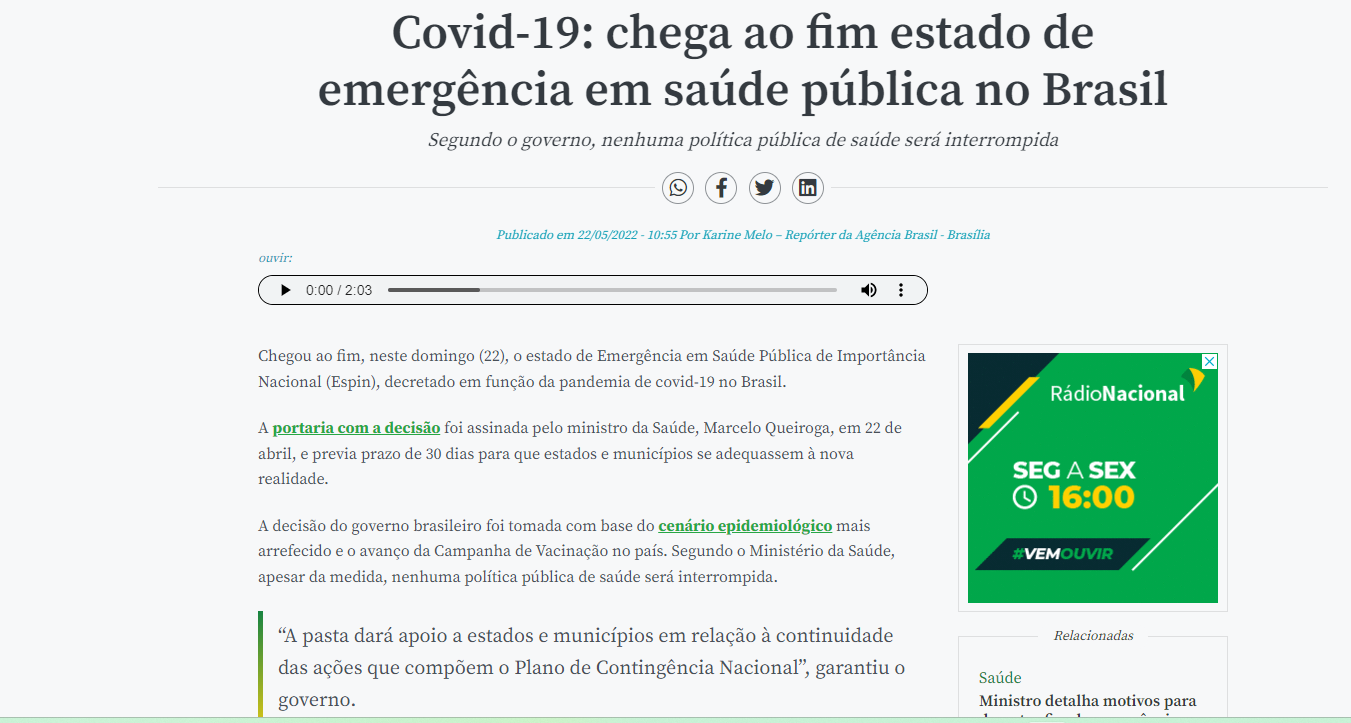


In [395]:
# Criando a coluna "Covid"
dados=dados.assign(Covid='xxx')
inicio_pandemia= pd.to_datetime('2020-03-15')
fim_pandemia=pd.to_datetime('2022-04-22')
for i in range(0,comp_dados):
    if dados['Data'][i]<inicio_pandemia:
        dados['Covid'][i]="Pré-Pandemia"
    elif dados['Data'][i]> fim_pandemia:
        dados['Covid'][i]="Pós-Pandemia"
    else:
        dados['Covid'][i]="Pandemia"
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-05-02           4514.13            53.00   
5            Sul 2023-05-01           4759.59            55.88   
9            Sul 2023-04-30           5107.28            78.51   
12           Sul 2023-04-29           5558.62            85.45   
17           Sul 2023-04-28           6061.60            93.18   
...          ...        ...               ...              ...   
26766   Nordeste 2005-01-05          11820.00            85.58   
26770   Nordeste 2005-01-04          11285.00            81.71   
26772   Nordeste 2005-01-03          10929.00            79.13   
26778   Nordeste 2005-01-02          10267.00            74.34   
26782   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     4302.37                  50.51  20459.24    17120.07   
5                     4196.79                  49.2

In [396]:
# Exibindo as informações do DataFrame "final", incorporada a coluna "Covid"
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26784 entries, 1 to 26782
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              26784 non-null  object        
 1   Data                    26784 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        26784 non-null  float64       
 3   ENA_Bruta[%MLT]         26784 non-null  float64       
 4   ENA_Armazenavel[MWmed]  26784 non-null  float64       
 5   ENA_Armazenavel[%MLT]   26784 non-null  float64       
 6   EAR_max                 26784 non-null  float64       
 7   EAR[MWmes]              26784 non-null  float64       
 8   EAR[%max]               26784 non-null  float64       
 9   Carga_Diaria[MWmed]     26784 non-null  float64       
 10  CMO_semanal[R$/MWh]     26784 non-null  float64       
 11  CMO_leve[R$/MWh]        26784 non-null  float64       
 12  CMO_media[R$/MWh]       26784 non-null  float6

Portanto, o dataframe "dados" possui todos os valores "não-nulos", sendo as colunas 'Subsistema' e 'Covid' qualitativas.

In [397]:
# Verificando a distribuição das classes (Covid)
dados.groupby('Covid').size()

Covid
Pandemia         3076
Pré-Pandemia    22208
Pós-Pandemia     1500
dtype: int64

Numa etapa futura, que objetivará a predição do CMO, espera-se que o período da pandemia mereça algum tipo de tratamento especial, de modo a evitar vieses incorretos nas saídas dos modelos de Machine Learning, a ser tratado nos próximos Sprints.

In [398]:
# Redefinindo os datasets por subsistema, incorporando a coluna "Covid"
filtro_SE = (dados['Subsistema'] == 'Sudeste')
dados_SE=dados.loc[filtro_SE]
filtro_S = (dados['Subsistema'] == 'Sul')
dados_S=dados.loc[filtro_S]
filtro_NE = (dados['Subsistema'] == 'Nordeste')
dados_NE=dados.loc[filtro_NE]
filtro_N = (dados['Subsistema'] == 'Norte')
dados_N=dados.loc[filtro_N]

In [399]:
print(dados_SE)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-05-02          48473.26           121.45   
4        Sudeste 2023-05-01          49685.99           124.49   
8        Sudeste 2023-04-30          51014.51            93.18   
15       Sudeste 2023-04-29          52400.80            95.71   
16       Sudeste 2023-04-28          53724.86            98.13   
...          ...        ...               ...              ...   
26764    Sudeste 2005-01-05          45324.00            90.05   
26768    Sudeste 2005-01-04          44388.00            88.19   
26775    Sudeste 2005-01-03          43314.00            86.06   
26776    Sudeste 2005-01-02          43352.00            86.13   
26780    Sudeste 2005-01-01          43952.00            87.32   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]    EAR_max  EAR[MWmes]  \
0                    35527.92                  89.02  204615.33   176293.97   
4                    31941.66                  80

## Visualizações Unimodais

### Histogramas

In [400]:
# Histograma para visualização dos dados de ENA_Bruta[MWmed];ENA_Bruta[%MLT]; EAR[MWmes]; EAR[%max]; Carga_Diaria[MWmed] e CMO_Semanal[R$/MWh]
# Carregando o estilo "seaborn-v0_8"
plt.style.use("seaborn-v0_8")

# Alterando alguns parâmetros gráficos
plt.rc("axes", facecolor="#fafafa", grid = True)
plt.rc("grid", color = "#f0f0f0")
plt.rc("axes", edgecolor="#cccccc", lw=0.1)

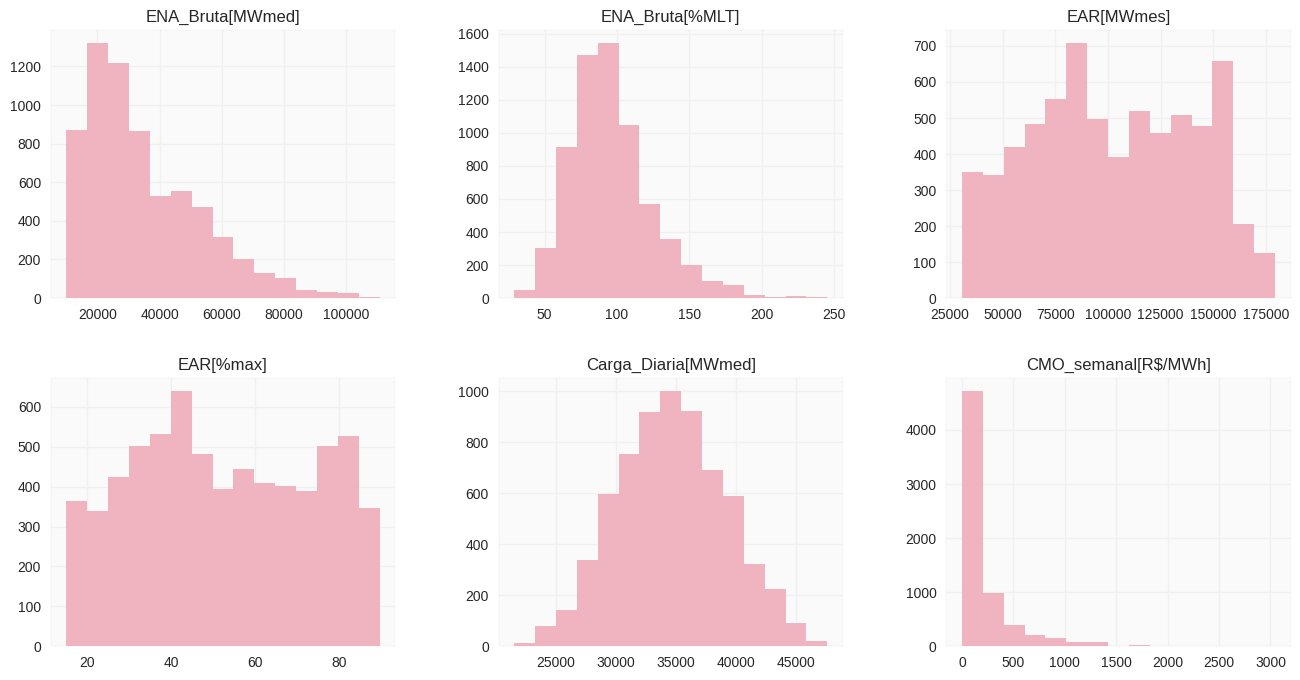

In [401]:
# Histograma Sudeste
dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#F0b3c0")
plt.show()

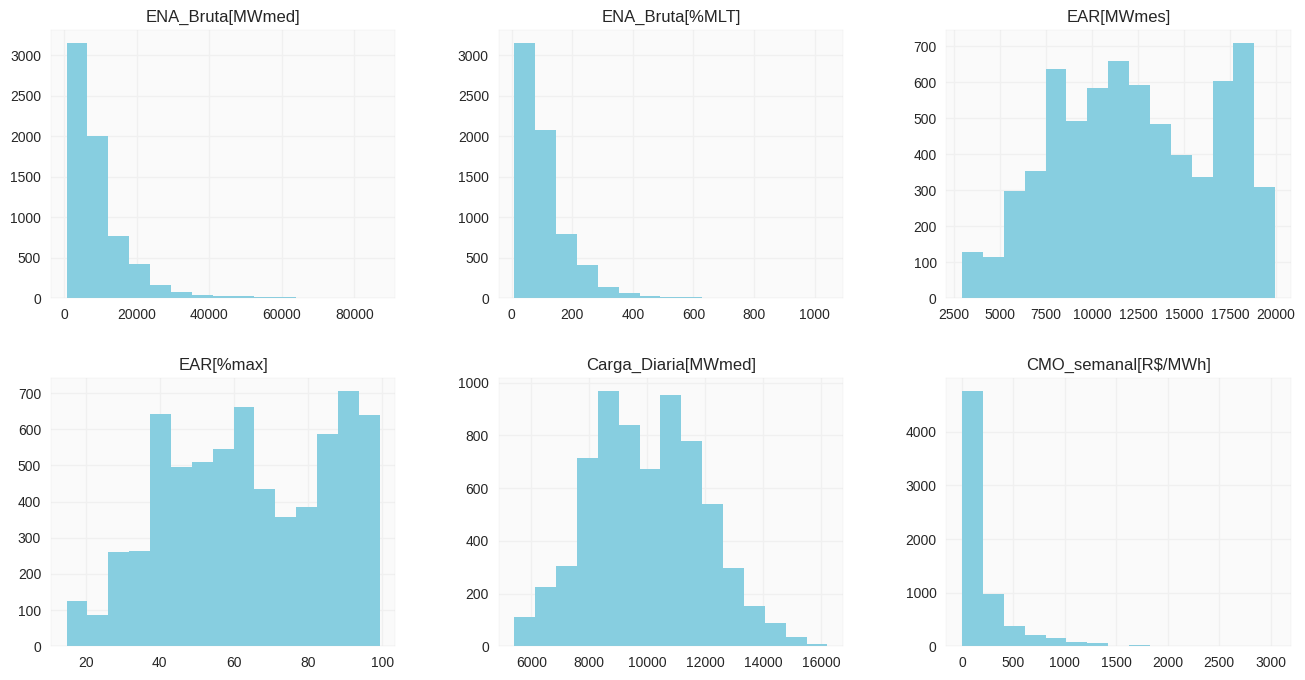

In [402]:
# Histograma Sul
dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#87cee0")
plt.bar_label
plt.show()

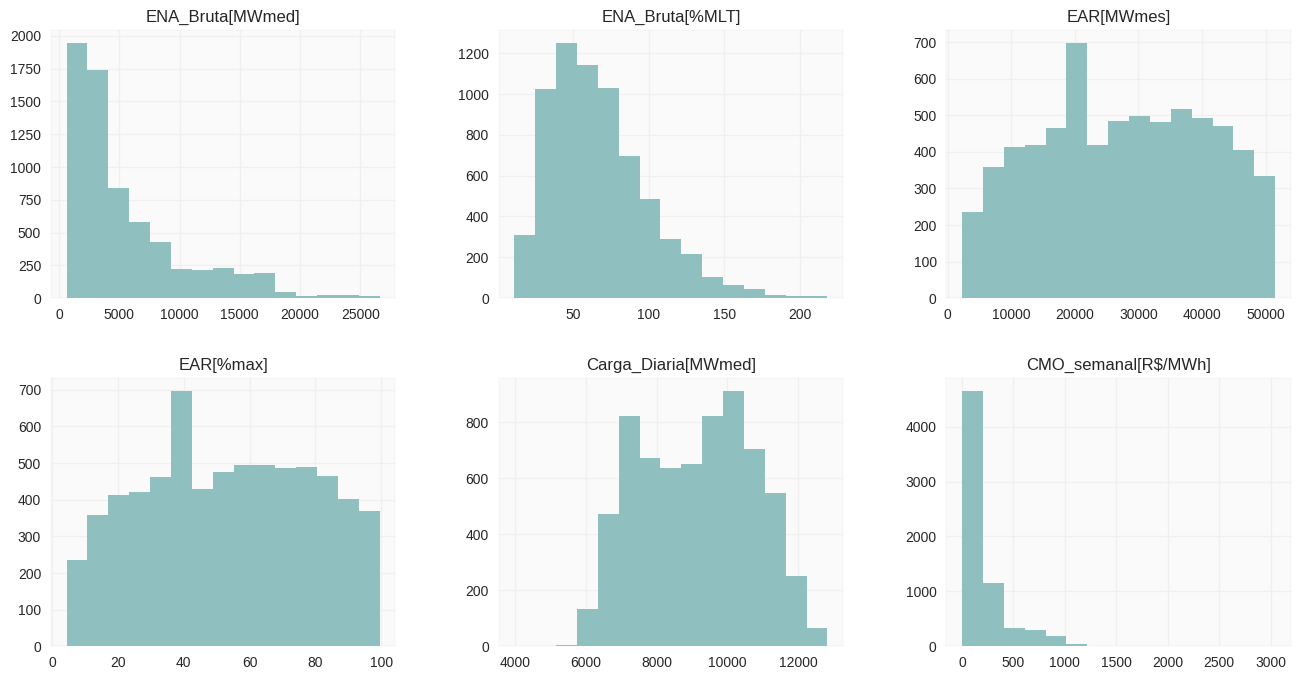

In [403]:
# Histograma Nordeste
dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#8FBfbF")
plt.show()

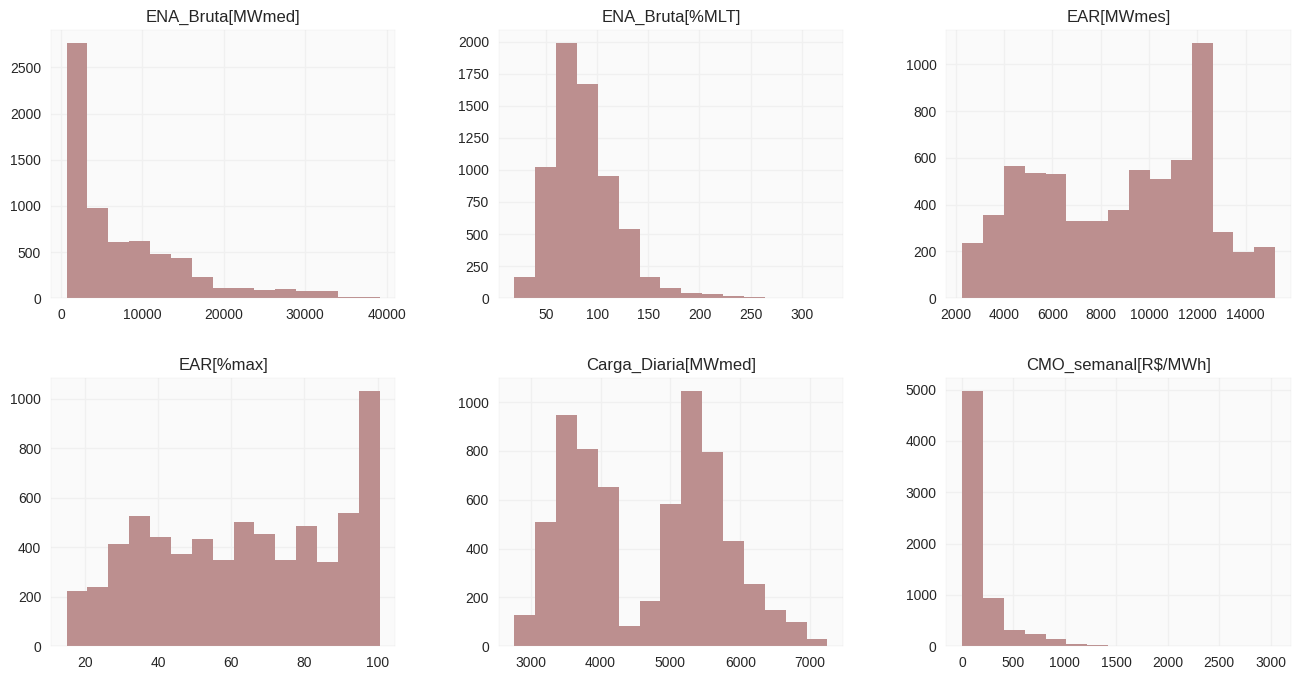

In [404]:
# Histograma Norte
dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15, layout = (2,3), figsize = (16,8), color="#BC8F8F")
plt.show()



> Pela análise dos histogramas, para todos os subsistemas o CMO semanal apresenta assimetria positiva, indicando que a enorme maioria dos valores encontra-se abaixo dos 250 Reais/MWh, embora haja valores extremos, ultrapassando os 3000 R$/MWh, conforme visto nas tabelas com as estatísticas descritivas.


> Em relação ao comportamento da carga diária, para o Sudeste, aproxima-se bastante de uma distribuição normal. Chama a atenção a carga do Norte: provavelmente, esse comportamento "dividido em dois blocos bem definidos" se deve à entrada/saída de algum grande consumidor, que faça com que a ocorrência de valores entre 4 e 5 GWmed seja baixa.


> Em relação aos reservatórios, é interessante observar como, para o subsistema Nordeste, a maior frequência de EAR (%máx) no período está na faixa dos 40%. E que Sudeste e Sul também tiveram reservatórios próximos a esse patamar em um número expressivo de dias.



> Sobre a ENA em % da MLT, todos os subsistemas apresentam assimetria à direita. Para o Sudeste, a maior frequência é próxima dos 80-100% da MLT.









### Boxplot

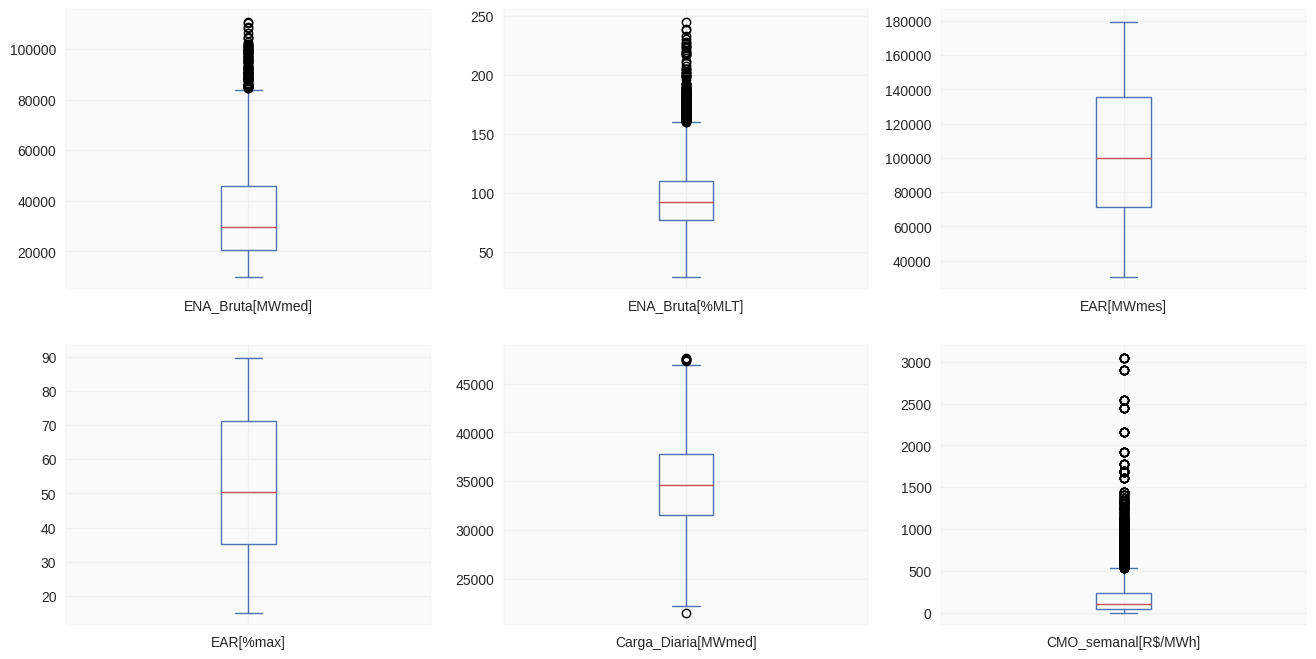

In [405]:
# Boxplot Sudeste
dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

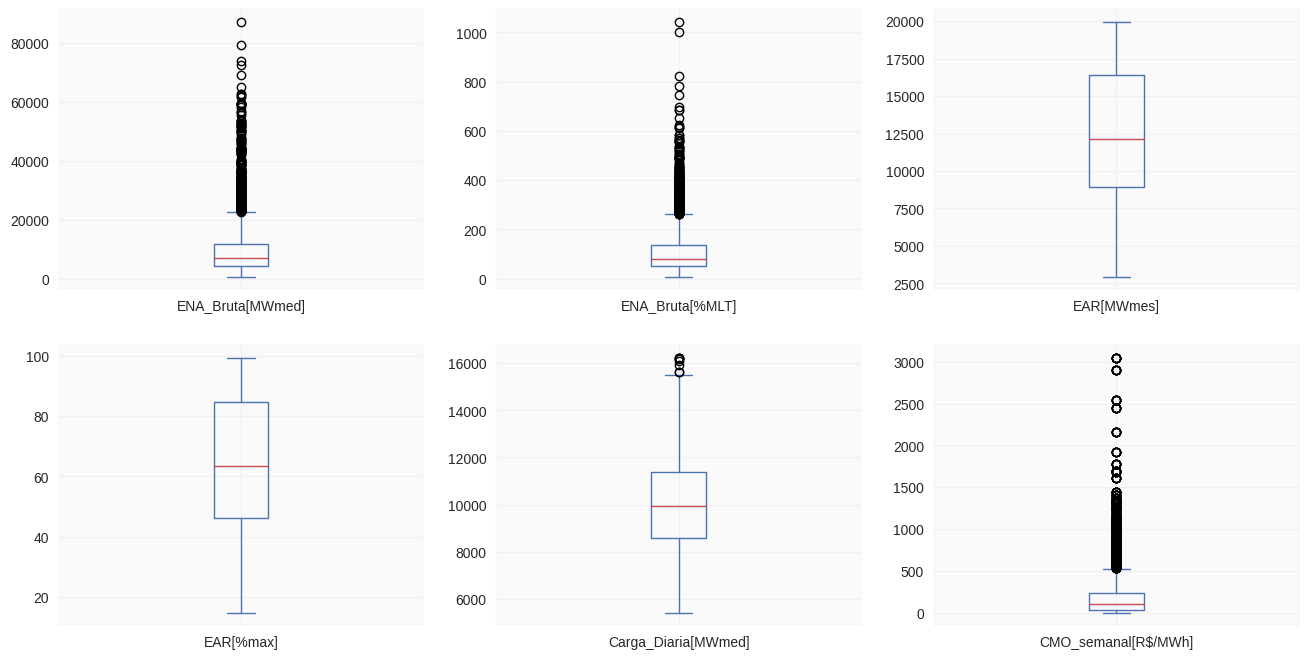

In [406]:
# Boxplot Sul
dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

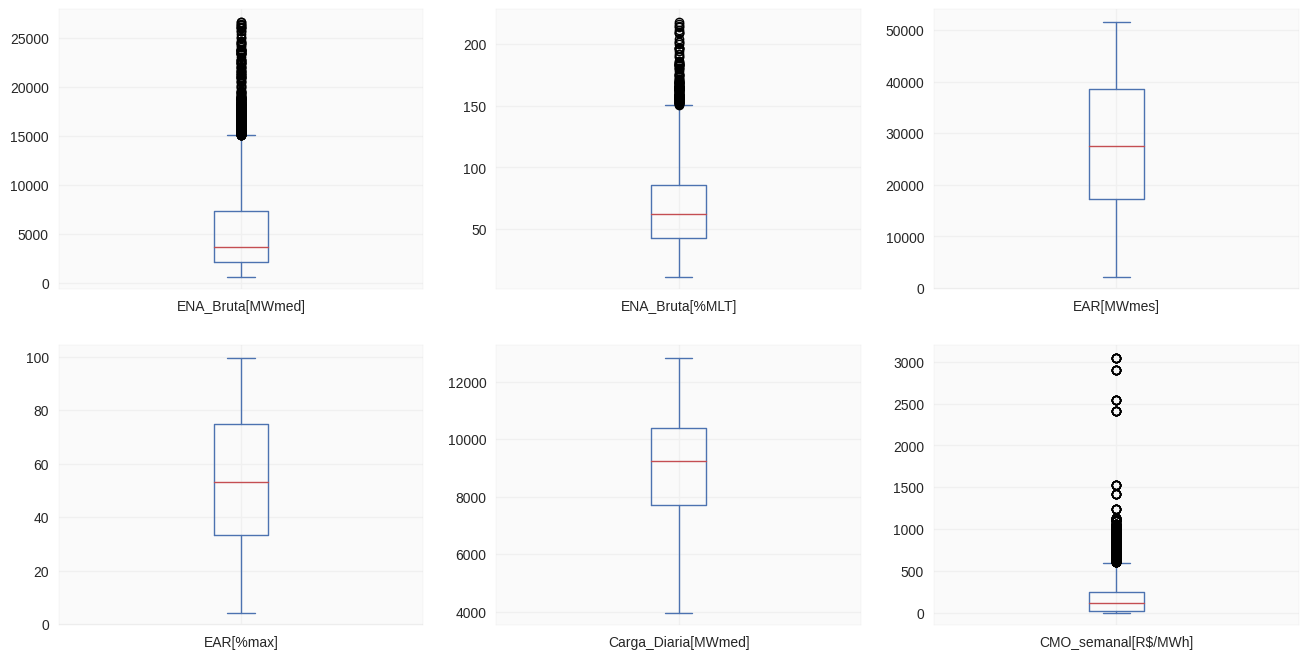

In [407]:
# Boxplot Nordeste
dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

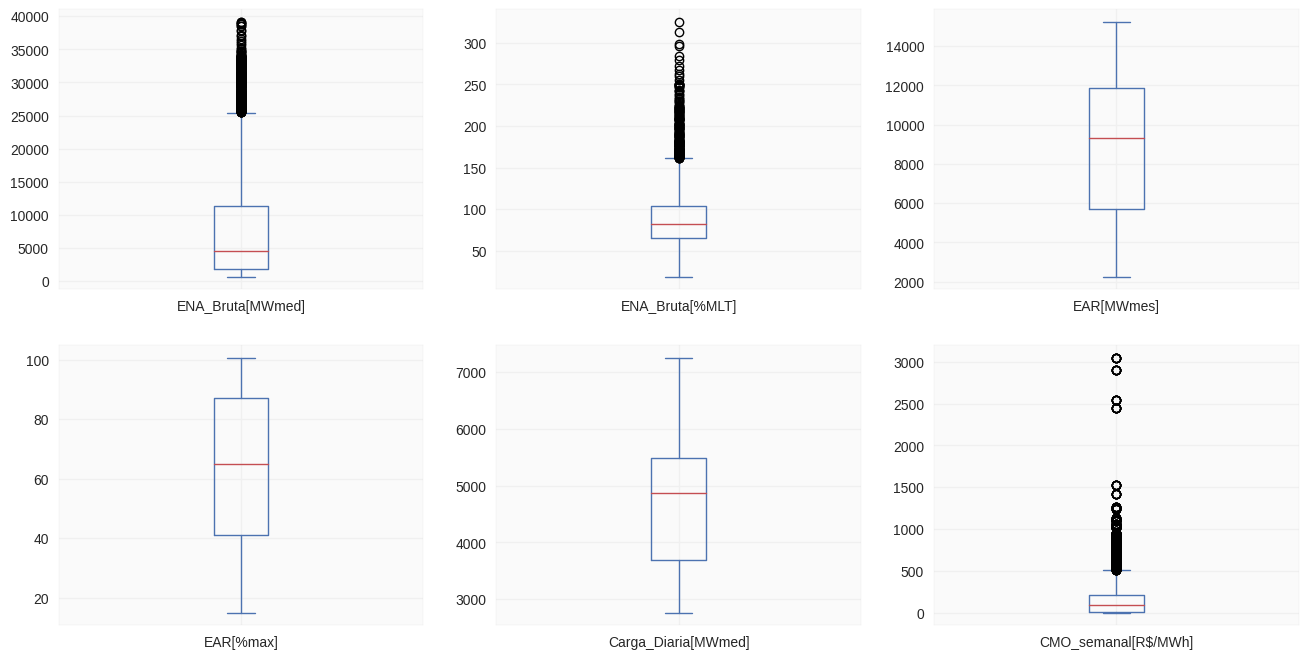

In [408]:
# Boxplot Norte
dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()



> A análise dos gráficos boxplot corrobora as constatações do histograma. Nas plotagens, a linha vermelha representa a mediana (imune a outliers). Para todos os subsistemas, observa-se que, em relação à Energia Armazenada, todos os valores encontram-se dentro dos limites do boxplot (tanto em MWmes quanto em %máximo). Este fato pode ser depreendido do histograma, pelo qual é possível perceber que não há diferenças significativas nas distribuições de probabilidade dos reservatórios, considerando um mesmo subsistema. Fato semelhante ocorre para os gráficos de carga diária. Neste ponto, destaca-se o fato de que, para a região Norte, o valor de P50 (próximo aos 5 GWmed) está bem mais próximo do valor correspondente ao terceiro quartil (P75) do que do primeiro (P25). Isso indica uma distribuição elevada de carga na faixa dos 5 ao 5,5 GWmed no referido subsistema. Para o Sul e Sudeste, alguns poucos valores acima do limite superior do intervalo.

> Em relação à ENA, no entanto, para todos os subsistemas se observam bastante valores fora dos limites do boxplot, característica das distribuições com assimetria à direita. Como destaque, para o Sul, houve uma ocorrência de ENA superior aos 1000% da MLT o que, certamente, configura um evento extremamente atípico em termos meteorológicos/climatológicos.


> Por fim, em relação ao CMO, observa-se que em 50% da amostra, os valores são inferiores a 150 Reais/MWh para os 4 subsistemas. O P75 não chega aos 250 Reais/MWh e o limite da faixa gira em torno dos 500 Reais/MWh. Nas etapas de predição/prescrição, faz-se necessário, portanto, maior atenção aos valores fora do intervalo, provavelmente correspondentes a períodos de grave escassez hídrica, como foi o biênio 2020-2021, quando os baixos valores de ENA e EArm levaram ao CMO de mais de 3000 Reais/MWh.






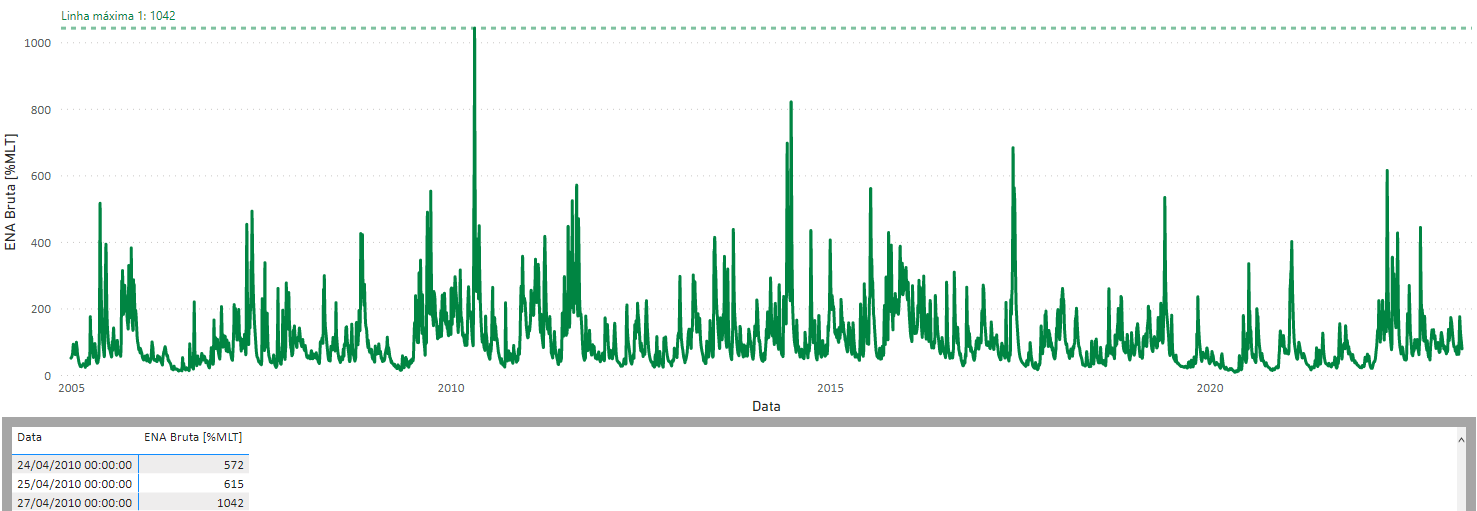
Data de ocorrência do evento de mais de 1000% da MLT na região Sul, correspondente a cerca de 60 GWmed (gráfico elaborado por meio do Power BI).

## Visualizações Multimodais

### Matriz de Correlação

<Axes: >

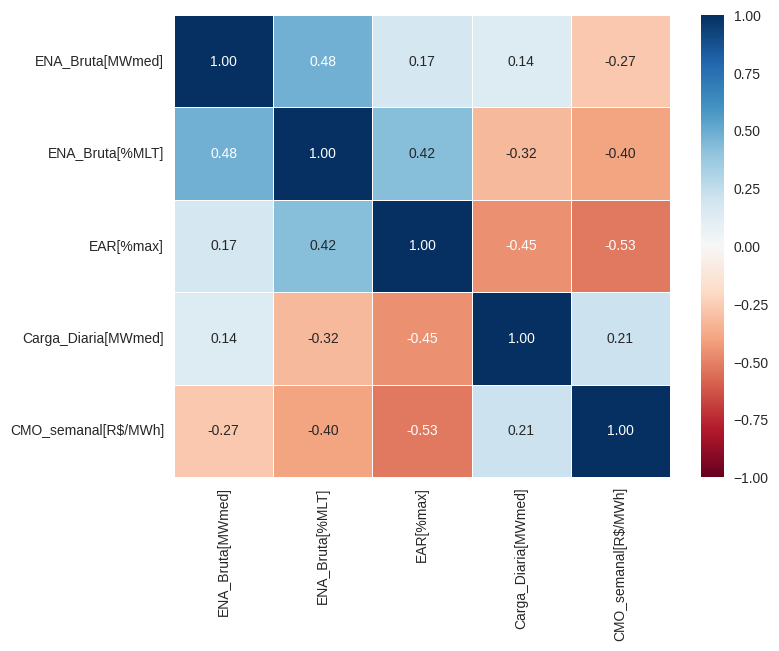

In [409]:
# Matriz de Correlação para o Sudeste
plt.figure(figsize=(8,6))
sns.heatmap(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True, 
            fmt = ".2f", cmap='RdBu', 
            linewidths=.5, 
            vmin = -1, vmax = 1)

<Axes: >

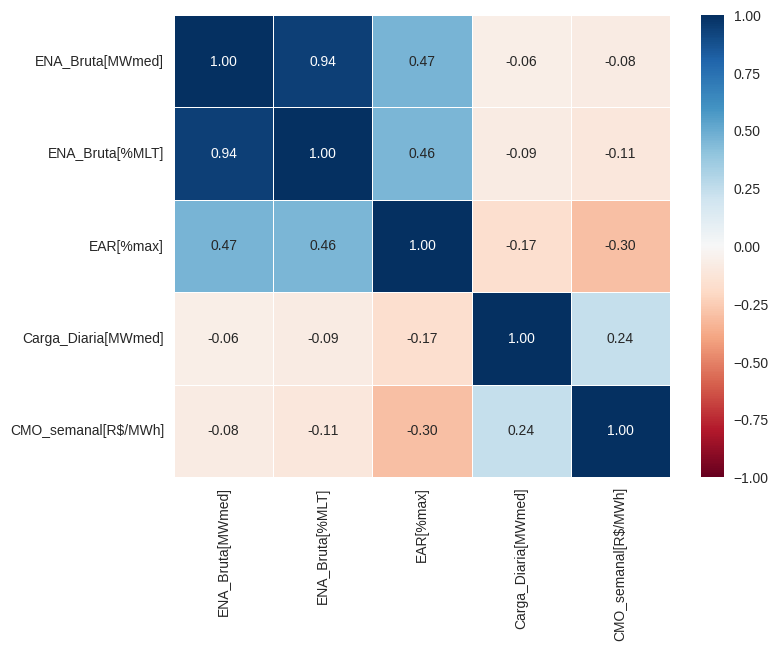

In [410]:
# Matriz de Correlação para o Sul
plt.figure(figsize=(8,6))
sns.heatmap(dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True, 
            fmt = ".2f", cmap='RdBu', 
            linewidths=.5, 
            vmin = -1, vmax = 1)

<Axes: >

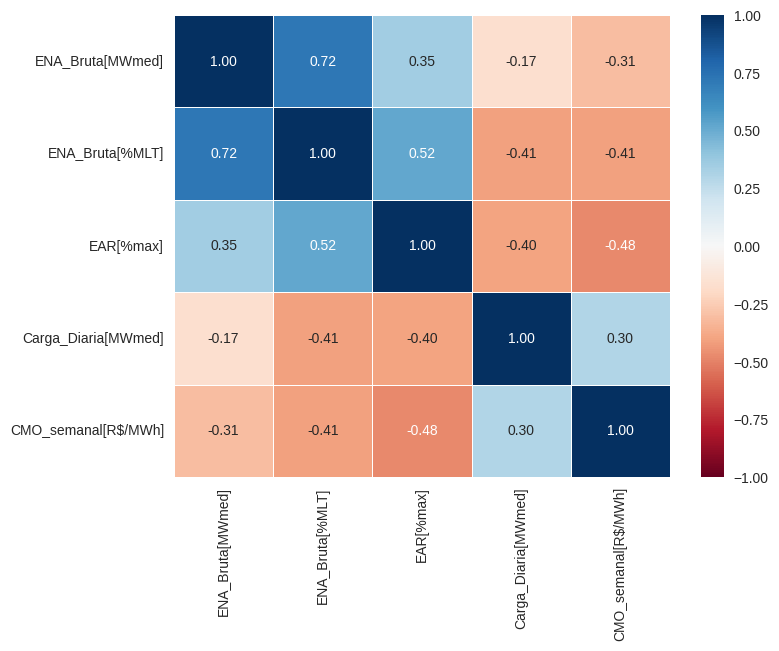

In [411]:
# Matriz de Correlação para o Nordeste
plt.figure(figsize=(8,6))
sns.heatmap(dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True, 
            fmt = ".2f", cmap='RdBu', 
            linewidths=.5, 
            vmin = -1, vmax = 1)

<Axes: >

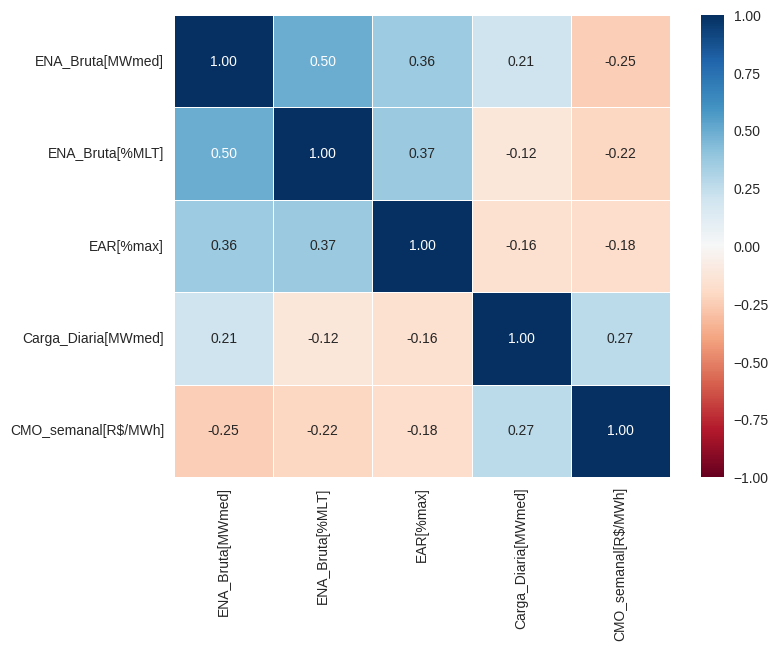

In [412]:
# Matriz de Correlação para o Norte
plt.figure(figsize=(8,6))
sns.heatmap(dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True, 
            fmt = ".2f", cmap='RdBu', 
            linewidths=.5, 
            vmin = -1, vmax = 1)

Conforme analisado anteriormente, considerando todo o horizonte de dados disponível (2005-dias atuais), é possível identificar uma correlação moderada (negativa) do CMO com a Energia Armazenada (em % do volume útil) e com a Energia Natural Afluente (em % da MLT) principalmente para o Sudeste e o Nordeste, que são os subsistemas com maior volume máximo de reservatórios do SIN. Para a carga, a correlação é positiva moderada, em todos os subsistemas, conforme esperado "intuitivamente". É possível constatar ainda que ENA (%MLT) e EArm (%máx) se correlacionam positivamente. Esse comportamento faz sentido, uma vez que na ocorrência de chuvas (e, consequentemente, de elevação da ENA) espera-se que os reservatórios (EArm) também se encham. As políticas operativas, no entanto, podem acabar levando a maiores ou menores deplecionamentos dos reservatórios das usinas hidroelétricas, por fora dos modelos, a depender da conjuntura hidrológica e do balanço energético do Sistema Interligado Nacional. 

### Scatter Plot

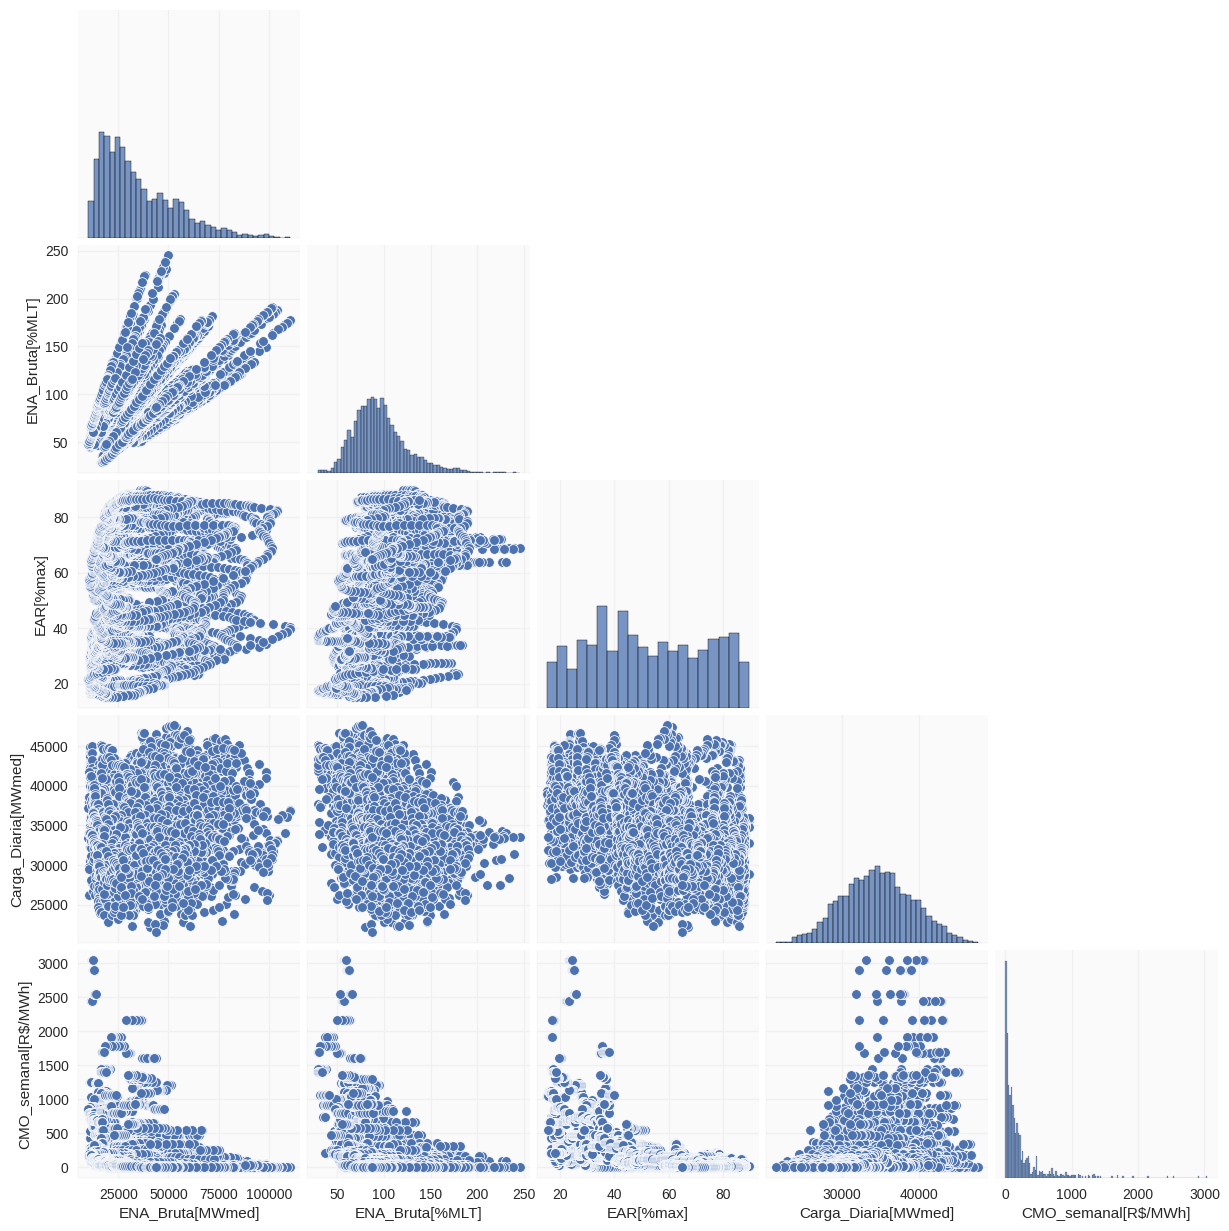

In [413]:
# Faremos a análise apenas para o subsistema sudeste, por ser o mais relevante para o SIN
# Scatter Plot com Seaborn - Sudeste
sns.pairplot(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']], corner=True)

Pela avaliação do scatter-plot, podemos observar como os maiores valores de CMO semanal ocorrem para valores de ENA Bruta inferiores a 75% da MLT e para reservatórios abaixo dos 40% do volume útil no Sudeste. É possível observar também que o CMO de 0 R$/MWh nunca ocorreu em casos de ENA diária inferior a 50% da MLT no Sudeste. Um outro destaque é o fato de os maiores valores de CMO não terem ocorrido para valores mínimos de ENA em % da MLT (e sim próximo aos 60%), mas, para ENAs muito baixas em termos absolutos (MWmed). Isto nos leva a crer que esses Custos muito elevados se deram em algum mês de MLT mais baixa (ou seja, de valores históricos de chuva mais baixos, pela sazonalidade/climatologia. Provavelmente, entre junho e novembro, meses do chamado "período seco"). Além disso, para reservatórios superiores a 50%-55%, o CMO não ultrapassou os 500 Reais/MWh que, como vimos no Boxplot, é o limite superior do mesmo. Em relação à carga, à exceção de valores outlier de CMO, o comportamento da curva Carga x CMO parece ter uma tendência de distribuição normal, para a qual valores mais elevados de CMO ocorrem em cargas intermediárias, entre 30 e 40 GWmed. Esse comportamento não é intuitivo, a princípio. Porém, como pode ser visto no gráfico de ENA Bruta (MWmed) x Carga, os maiores valores de ENA ocorreram para cargas de aproximadamente 35 GWmed e isso poderia explicar o comportamento do CMO (embora essa relação ENA x Carga possa ser uma coincidência em função da pandemia - menor carga e El Niño - condições climáticas - menor ENA). Para trabalhos futuros, fazem-se necessárias avaliações mais detalhadas a respeito.

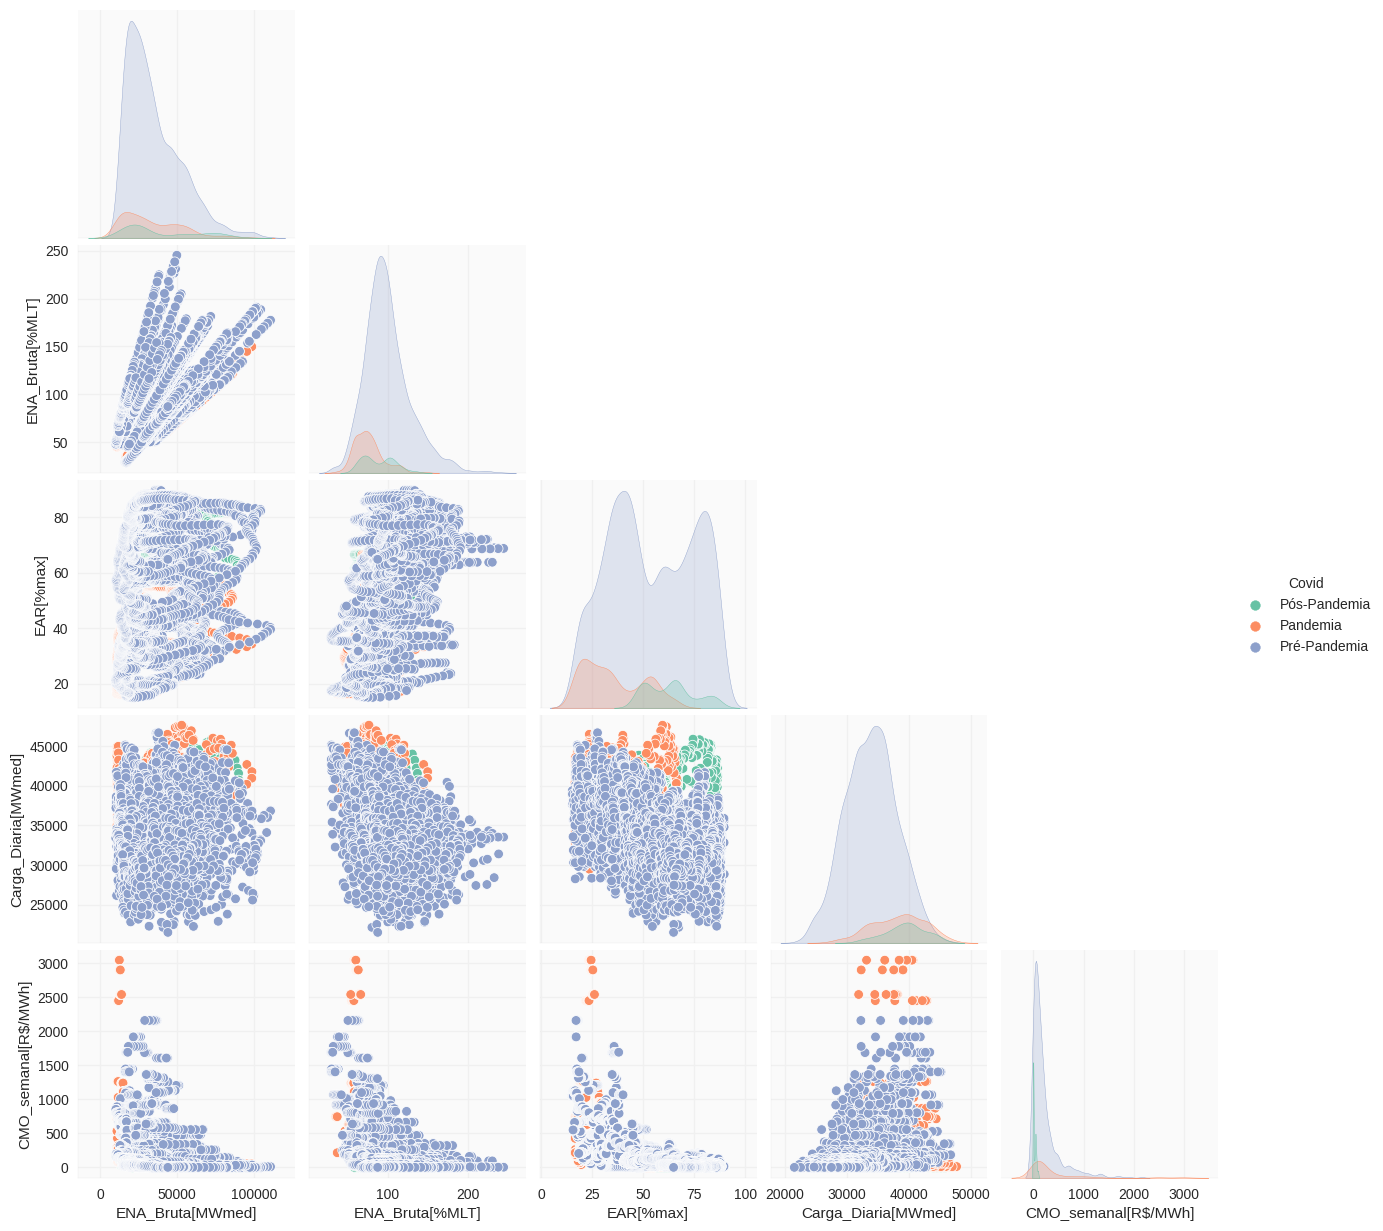

In [414]:
# Scatter Plot considerando a variável qualitativa referente à pandemia de Covid-19
# Faremos a análise apenas para o subsistema sudeste, por ser o mais relevante para o SIN
sns.pairplot(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]','Covid']], hue = "Covid", height = 2.5, corner=True, palette="Set2")

A principal interferência da pandemia de Covid-19 nas grandezas avaliadas diz respeito à carga. Embora, coincidentemente (mas sem nenhum tipo de relação causal), os valores de ENA (em MWmed e em % da MLT) tenham tido uma distribuição mais assimétrica à direita no período da pandemia do que no período anterior a ela. É necessário, em análises futuras (e no treinamento dos modelos de ML) cautela neste aspecto, para que os algoritmos não indiquem correlações indevidas entre a pandemia e a ENA. Em relação à carga, durante a pandemia (e no pós), o que enxergamos é um deslocamento da curva para uma assimetria mais à esquerda. Para análises futuras, é interessante avaliar os anos imediatamente anteriores à pandemia (talvez encurtar o horizonte, neste caso, por exemplo), para tentar entender melhor os efeitos. Além disso, no durante e pós-pandemia observa-se um desvio-padrão maior (da carga) em comparação aos anos prévios. Sobre a correlação com o CMO, observamos que os maiores valores de CMO registrados ocorreram durante a pandemia, mesmo para cargas intermediárias que, fora da pandemia, levaram o custo no máximo a 70% dos 3000 Reais/MWh). E este fato provavelmente se explica pelos valores mais severos de ENA e EArm no intervalo de 2020 a 2022.

## Avaliações Temporais no Power BI

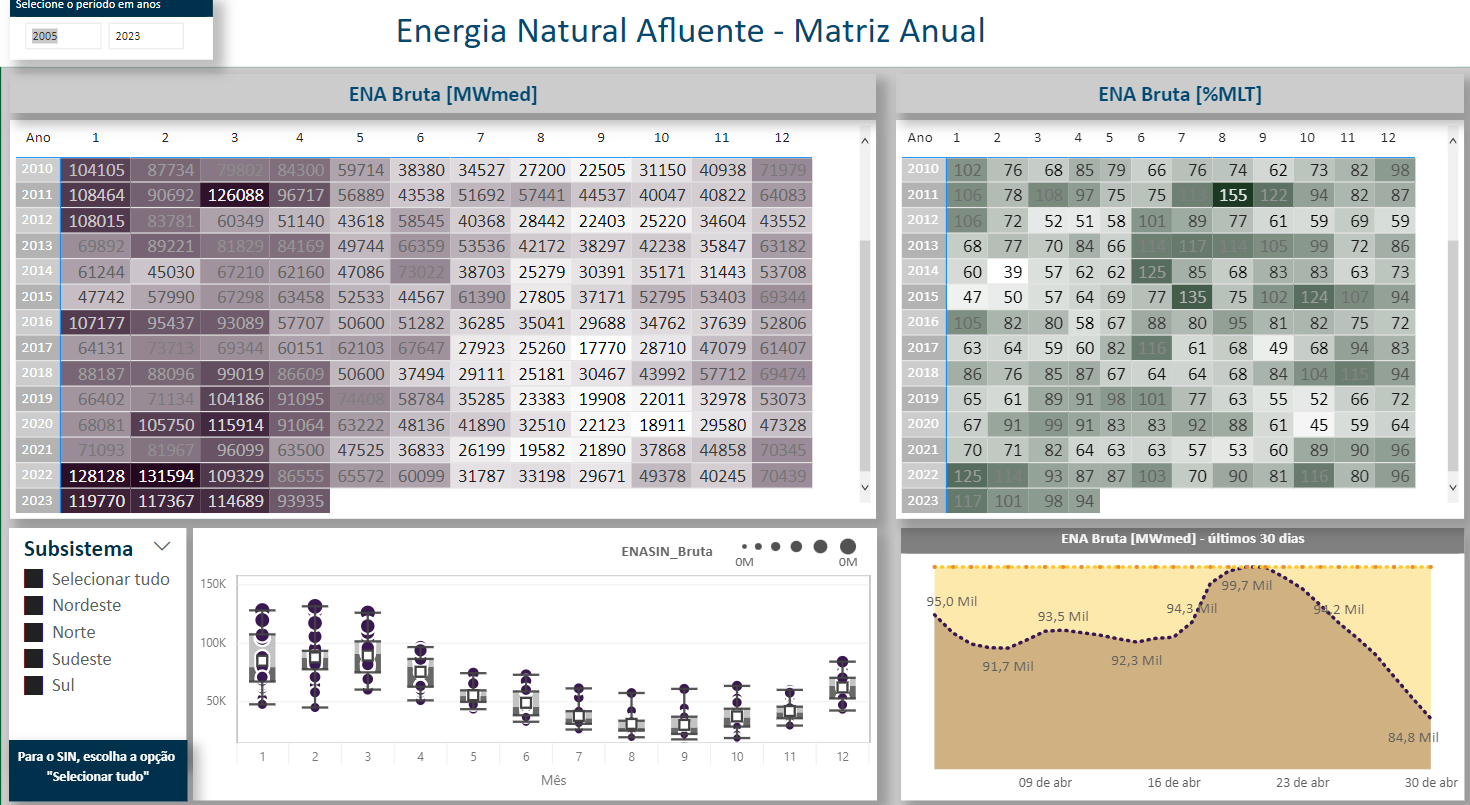

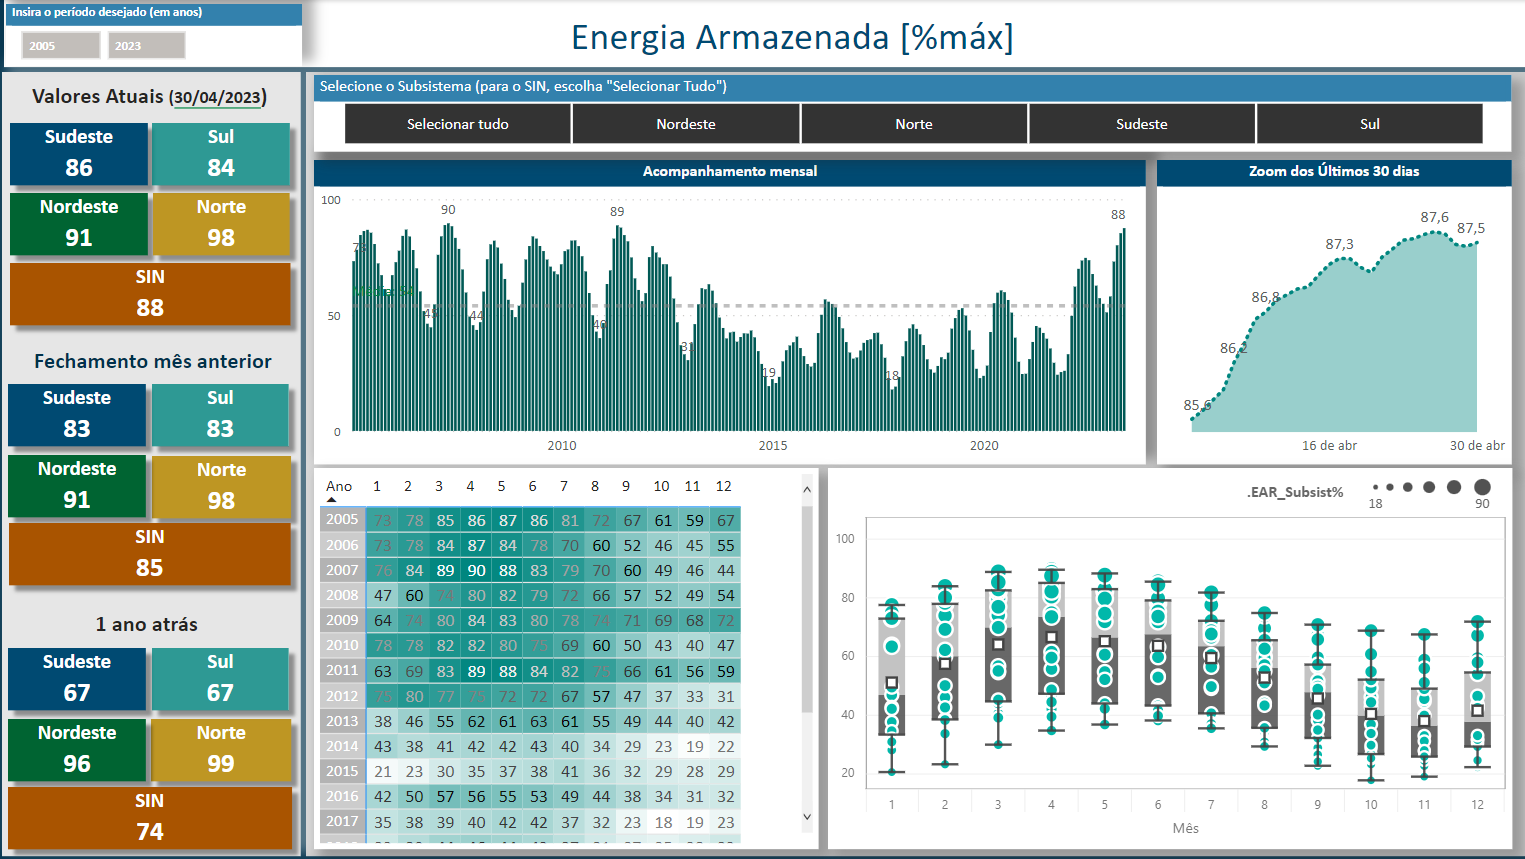

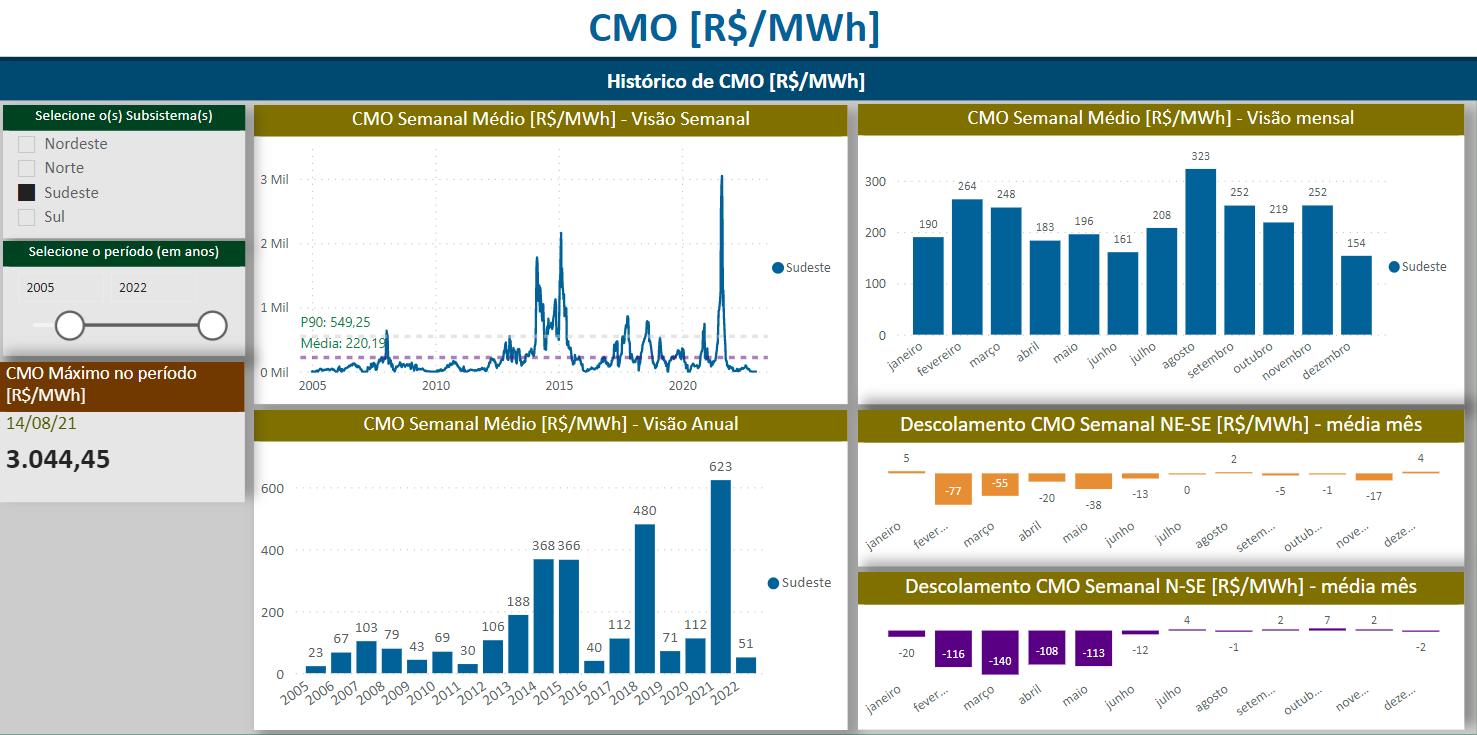

Os dados obtidos a partir da Área de Dados Abertos do ONS foram importados no Power BI (via Power Query) e, em seguida, foram gerados os dashboard acima. Pelas visualizações, pode-se concluir, por exemplo, que: desde 2011, o mês de abril não registrava ENA (% da MLT) tão alta. Além disso, pelo boxplot de ENA é possível identificar a sazonalidade do período chuvoso/seco no Brasil, de modo que dezembro a abril são os meses de maior mediana (período úmido). Em relação ao histórico recente, observa-se uma queda de mais de 10 GWmed de ENA no SIN entre o final de março e o final de abril o que é, de certa forma, esperado pela climatologia dos referidos meses. Apesar da redução da ENA (em termos absolutos) os reservatórios do SIN sofreram uma elevação no último mês. Quando comparados ao mesmo período de 2022 (30/04/23 vs 30/04/22), a crescente é muito expressiva, principalmente no Sul e no Sudeste. Podemos perceber que o enchimento/deplecionamento dos reservatórios tem um comportamento cíclico ao longo de um ano e que, desde 2011, não observávamos condições tão favoráveis de energia armazenada quanto atualmente. Em relação ao CMO médio no decorrer dos anos, observa-se que, de fato, 2011 teve valores baixíssimos do custo de operação médio. Também é possível observar que em 2021, quando as ENAs ficaram muito baixas, o preço médio anual foi o maior do histórico e que basta um ano favorável ou desfavorável em termos de chuva para alterar a tendência de CMO do ano anterior. Em relação aos valores médios nos meses, observa-se que agosto (mês de menor MLT no Sudeste) é o de maior CMO médio, ao passo que dezembro (início do período úmido), o de menor. Em relação aos valores por subsistema, observa-se que nos meses chuvosos, dentro do horizonte analisado, em geral o CMO do Nordeste e do Norte foi menor que o do Sudeste. Este aspecto está diretamente relacionado à capacidade de fluxo de energia entre os subsistemas e, considerando ampliações e reforços na transmissão, pode não ser mais replicável daqui em diante. Este aspecto não está explícito pelos dados do presente trabalho mas, em etapas futuras, faz-se pertinente a inclusão.


# **Seção IV: Pré-Processamento de Dados - Parte 2**


> Ao longo das seções/etapas anteriores, já realizamos várias atividades de pré-processamento de dados, de modo a deixar nosso DataFrame mais "enxuto", menos "redundante" e mais adequado para aplicação de Modelos de Machine Learning. Neste momento, iremos reduzir ainda mais a dimensionalidade e realizar algumas transformações numéricas.



## Redução da Dimensionalidade

In [415]:
# Reduzindo a dimensionalidade do dataset dados, excluindo as colunas de CMO por patamar
dados=dados[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]','Covid']]
dados_SE=dados_SE[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]','Covid']]
dados_S=dados_S[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]','Covid']]
dados_NE=dados_NE[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]','Covid']]
dados_N=dados_N[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]','Covid']]

# Avaliando as 20 primeiras linhas do dataset dados
dados.head(20)

Data Subsistema  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1  2023-05-02        Sul           4514.13            53.00   
5  2023-05-01        Sul           4759.59            55.88   
9  2023-04-30        Sul           5107.28            78.51   
12 2023-04-29        Sul           5558.62            85.45   
17 2023-04-28        Sul           6061.60            93.18   
21 2023-04-27        Sul           6538.16           100.51   
25 2023-04-26        Sul           6835.11           105.07   
28 2023-04-25        Sul           7150.46           109.92   
33 2023-04-24        Sul           7548.06           116.03   
37 2023-04-23        Sul           8157.38           125.40   
41 2023-04-22        Sul           8886.95           136.62   
44 2023-04-21        Sul           9779.88           150.34   
49 2023-04-20        Sul          10810.46           166.19   
53 2023-04-19        Sul          11366.67           174.74   
58 2023-04-18        Sul           9947.35           152.92   
60 2023-04-17        Sul           6805.00           104.61   
65 2023-04-16        Sul           4786.15            73.58   
69 2023-04-15        Sul           4288.05            65.92   
73 2023-04-14        Sul           4030.83            61.96   
76 2023-04-13        Sul           4260.46            65.49   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[%max]  \
1                  4302.37                  50.51  20459.24      83.68   
5                  4196.79                  49.27  20459.24      84.01   
9                  4844.18                  74.47  20459.24      84.05   
12                 5203.18                  79.99  20459.24      83.99   
17                 5920.48                  91.01  20459.24      83.98   
21                 6169.30                  94.84  20459.24      84.23   
25                 4295.60                  66.04  20459.24      84.51   
28                 4890.04                  75.17  20459.24      84.71   
33                 6535.83                 100.47  20459.24      84.99   
37                 3098.84                  47.64  20459.24      84.83   
41                 3766.16                  57.90  20459.24      84.94   
44                 5898.13                  90.67  20459.24      84.96   
49                 7099.16                 109.13  20459.24      84.87   
53                 6831.64                 105.02  20459.24      85.01   
58                 3562.37                  54.76  20459.24      84.80   
60                 6298.04                  96.82  20459.24      84.75   
65                 4469.45                  68.71  20459.24      84.32   
69                 4003.65                  61.55  20459.24      84.04   
73                 3926.07                  60.35  20459.24      83.91   
76                 4155.40                  63.88  20459.24      84.04   

    Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]         Covid  
1              13033.73                  0.0  Pós-Pandemia  
5              10072.19                  0.0  Pós-Pandemia  
9               9635.53                  0.0  Pós-Pandemia  
12             11012.29                  0.0  Pós-Pandemia  
17             12247.46                  0.0  Pós-Pandemia  
21             12578.77                  0.0  Pós-Pandemia  
25             12626.74                  0.0  Pós-Pandemia  
28             12557.10                  0.0  Pós-Pandemia  
33             11822.70                  0.0  Pós-Pandemia  
37              8646.55                  0.0  Pós-Pandemia  
41              9310.24                  0.0  Pós-Pandemia  
44              9641.26                  0.0  Pós-Pandemia  
49             11225.17                  0.0  Pós-Pandemia  
53             11500.87                  0.0  Pós-Pandemia  
58             12071.94                  0.0  Pós-Pandemia  
60             12421.00                  0.0  Pós-Pandemia  
65              9788.41                  0.0  Pós-Pandemia  
69             11277.52         

In [416]:
# Confirmando novamente a ausência de dados faltantes
dados.isnull().sum()

Data                      0
Subsistema                0
ENA_Bruta[MWmed]          0
ENA_Bruta[%MLT]           0
ENA_Armazenavel[MWmed]    0
ENA_Armazenavel[%MLT]     0
EAR_max                   0
EAR[%max]                 0
Carga_Diaria[MWmed]       0
CMO_semanal[R$/MWh]       0
Covid                     0
dtype: int64

In [417]:
# Exibindo as dimensões de cada dataset
print("SIN:")
print(dados.shape)
print("Sudeste:")
print(dados_SE.shape)
print("Sul:")
print(dados_S.shape)
print("Nordeste:")
print(dados_NE.shape)
print("Norte:")
print(dados_N.shape)

SIN:
(26784, 11)
Sudeste:
(6696, 12)
Sul:
(6696, 12)
Nordeste:
(6696, 12)
Norte:
(6696, 12)


## Preparação para os Algoritmos de ML

A Normalização e a padronização são técnicas frequentemente aplicadas na etapa de preparação dos dados, com o objetivo de colocá-los em um intervalo de valores comuns. Não são técnicas obrigatórias para todos os algoritmos de Machine Learning mas podem impactar na acurácia do modelo a ser utilizado. 

Alterando os dados da coluna 'Covid' de qualitativos (categóricos) para codificação ordinal, de modo que "Pré-Pandemia"=0; "Pandemia"=1 e "Pós-Pandemia"=2

In [418]:
# Armazenando os datasets com a coluna 'Covid' original
dados_pandemia=dados
dados_pandemia_SE=dados_SE
dados_pandemia_S=dados_S
dados_pandemia_NE=dados_NE
dados_pandemia_N=dados_N

In [419]:
# Aplicando Ordinal Encoding
dados['Covid']=dados['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_SE['Covid']=dados_SE['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_S['Covid']=dados_S['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_NE['Covid']=dados_NE['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_N['Covid']=dados_N['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados.head(20)

Data Subsistema  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1  2023-05-02        Sul           4514.13            53.00   
5  2023-05-01        Sul           4759.59            55.88   
9  2023-04-30        Sul           5107.28            78.51   
12 2023-04-29        Sul           5558.62            85.45   
17 2023-04-28        Sul           6061.60            93.18   
21 2023-04-27        Sul           6538.16           100.51   
25 2023-04-26        Sul           6835.11           105.07   
28 2023-04-25        Sul           7150.46           109.92   
33 2023-04-24        Sul           7548.06           116.03   
37 2023-04-23        Sul           8157.38           125.40   
41 2023-04-22        Sul           8886.95           136.62   
44 2023-04-21        Sul           9779.88           150.34   
49 2023-04-20        Sul          10810.46           166.19   
53 2023-04-19        Sul          11366.67           174.74   
58 2023-04-18        Sul           9947.35           152.92   
60 2023-04-17        Sul           6805.00           104.61   
65 2023-04-16        Sul           4786.15            73.58   
69 2023-04-15        Sul           4288.05            65.92   
73 2023-04-14        Sul           4030.83            61.96   
76 2023-04-13        Sul           4260.46            65.49   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[%max]  \
1                  4302.37                  50.51  20459.24      83.68   
5                  4196.79                  49.27  20459.24      84.01   
9                  4844.18                  74.47  20459.24      84.05   
12                 5203.18                  79.99  20459.24      83.99   
17                 5920.48                  91.01  20459.24      83.98   
21                 6169.30                  94.84  20459.24      84.23   
25                 4295.60                  66.04  20459.24      84.51   
28                 4890.04                  75.17  20459.24      84.71   
33                 6535.83                 100.47  20459.24      84.99   
37                 3098.84                  47.64  20459.24      84.83   
41                 3766.16                  57.90  20459.24      84.94   
44                 5898.13                  90.67  20459.24      84.96   
49                 7099.16                 109.13  20459.24      84.87   
53                 6831.64                 105.02  20459.24      85.01   
58                 3562.37                  54.76  20459.24      84.80   
60                 6298.04                  96.82  20459.24      84.75   
65                 4469.45                  68.71  20459.24      84.32   
69                 4003.65                  61.55  20459.24      84.04   
73                 3926.07                  60.35  20459.24      83.91   
76                 4155.40                  63.88  20459.24      84.04   

    Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  Covid  
1              13033.73                  0.0      2  
5              10072.19                  0.0      2  
9               9635.53                  0.0      2  
12             11012.29                  0.0      2  
17             12247.46                  0.0      2  
21             12578.77                  0.0      2  
25             12626.74                  0.0      2  
28             12557.10                  0.0      2  
33             11822.70                  0.0      2  
37              8646.55                  0.0      2  
41              9310.24                  0.0      2  
44              9641.26                  0.0      2  
49             11225.17                  0.0      2  
53             11500.87                  0.0      2  
58             12071.94                  0.0      2  
60             12421.00                  0.0      2  
65              9788.41                  0.0      2  
69             11277.52                  0.0      2  
73             13234.98                  0.0      2  
76             13762.32                  0.0      

In [420]:
# Separando cada dataset (por subsistema) em componentes de "entrada" e "saída"
# SIN
X= dados.values[:,2:10]
y=dados.values[:,9]
# Sudeste
X_SE= dados_SE.values[:,2:10]
y_SE=dados_SE.values[:,9]
# Sul
X_S= dados_S.values[:,2:10]
y_S=dados_S.values[:,9]
# Nordeste
X_NE= dados_NE.values[:,2:10]
y_NE=dados_NE.values[:,9]
# Norte
X_N= dados_N.values[:,2:10]
y_N=dados_N.values[:,9]

Neste momento, realizaremos a análise apenas para o subsistema Sudeste, normalizando e padronizando os dados quantitativos do dataset dados_SE

### Normalização dos Dados

In [421]:
# Normalizando os dados
rescaledX_norm = MinMaxScaler().fit_transform(X_SE)

# Exibindo os dados transformados
print("Dados Originais: \n\n", dados_SE.values)
print("\nDados Normalizados (não inclui a coluna class): \n\n", rescaledX_norm)

Dados Originais: 

 [[Timestamp('2023-05-02 00:00:00') 'Sudeste' 48473.26 ... 2 0.0 2]
 [Timestamp('2023-05-01 00:00:00') 'Sudeste' 49685.99 ... 2 0.0 2]
 [Timestamp('2023-04-30 00:00:00') 'Sudeste' 51014.51 ... 2 0.0 2]
 ...
 [Timestamp('2005-01-03 00:00:00') 'Sudeste' 43314.0 ... 0 0.0 0]
 [Timestamp('2005-01-02 00:00:00') 'Sudeste' 43352.0 ... 0 0.0 0]
 [Timestamp('2005-01-01 00:00:00') 'Sudeste' 43952.0 ... 0 0.0 0]]

Dados Normalizados (não inclui a coluna class): 

 [[0.38173198 0.42759291 0.34532354 ... 0.95355705 0.73551536 1.        ]
 [0.39376876 0.44166242 0.29913266 ... 0.95449664 0.5116954  1.        ]
 [0.4069548  0.29675568 0.30133153 ... 0.95422819 0.49998257 1.        ]
 ...
 [0.33052446 0.2638034  0.43522669 ... 0.66926174 0.22828458 0.        ]
 [0.33090162 0.26412737 0.40982741 ... 0.66818792 0.03839024 0.        ]
 [0.33685684 0.26963484 0.40314271 ... 0.66657718 0.         0.        ]]


### Padronização dos Dados

In [422]:
# Padronizando os dados
rescaledX_padr = StandardScaler().fit_transform(X_SE)

# Exibindo os dados transformados
print("Dados Originais: \n\n", dados_SE.values)
print("\nDados Padronizados (não inclui a coluna class): \n\n", rescaledX_padr)

Dados Originais: 

 [[Timestamp('2023-05-02 00:00:00') 'Sudeste' 48473.26 ... 2 0.0 2]
 [Timestamp('2023-05-01 00:00:00') 'Sudeste' 49685.99 ... 2 0.0 2]
 [Timestamp('2023-04-30 00:00:00') 'Sudeste' 51014.51 ... 2 0.0 2]
 ...
 [Timestamp('2005-01-03 00:00:00') 'Sudeste' 43314.0 ... 0 0.0 0]
 [Timestamp('2005-01-02 00:00:00') 'Sudeste' 43352.0 ... 0 0.0 0]
 [Timestamp('2005-01-01 00:00:00') 'Sudeste' 43952.0 ... 0 0.0 0]]

Dados Padronizados (não inclui a coluna class): 

 [[ 0.74323101  0.88520847  0.26457726 ...  1.62997655  1.33783488
   3.3075294 ]
 [ 0.8093511   0.99132178  0.02319005 ...  1.63335269  0.04668885
   3.3075294 ]
 [ 0.88178425 -0.10157552  0.03468102 ...  1.63238808 -0.02087876
   3.3075294 ]
 ...
 [ 0.46193943 -0.35010406  0.73439876 ...  0.60845383 -1.58821796
  -0.4231565 ]
 [ 0.46401125 -0.34766067  0.60166561 ...  0.60459539 -2.68365792
  -0.4231565 ]
 [ 0.49672427 -0.30612289  0.56673229 ...  0.59880773 -2.90511898
  -0.4231565 ]]


# **Seção V: Conclusão**

O presente trabalho teve como objetivo a obtenção, tratamento e análise dos dados históricos de Energia Natural Afluente, Energia Armazenada, Demanda Elétrica e Custo Marginal da Operação, a partir dos dados diários por subsistema publicados pelo Operador Nacional do Sistema Elétrico. Puderam-se observar os comportamentos das referidas grandezas no período de 2005 a abril/2023, tanto ao longo do tempo, quanto em termos de distribuição (unimodal). Além disso, também foi possível avaliar as correlações entre as mesmas.

As etapas até aqui realizadas visam a, em um próximo momento, possibilitar a elaboração de algoritmos de aprendizagem de máquina no intuito de levar a predições/prescrições sobre expectativas de Custo Marginal da Operação frente a cenários futuros de ENA, EArm e Carga, considerando o histórico das mesmas e do próprio CMO.